# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados do Experimento Univariado com Regressão Múltipla para a Previsão de 2021 

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Análise Univariada de Regressão Múltipla da Série de Arrecadação do ICMS Paulista 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(15,8)})

2023-08-20 16:43:08.400129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

date       icms_sp    igp_m   dolar  ibc_br  dias_uteis  igp_m_22  \
0 2003-01-01  3.360296e+09  277.173  3.4384   96.15          22   277.173   
1 2003-02-01  3.196558e+09  283.506  3.5908   98.67          20   283.506   
2 2003-03-01  3.160011e+09  287.855  3.4469  103.41          19   287.855   
3 2003-04-01  3.215307e+09  290.512  3.1187  102.19          20   290.512   
4 2003-05-01  3.098930e+09  289.747  2.9557  100.30          21   289.747   

   dolar_22  ibc_br_22  igp_m_21  ...  ibc_br_16  igp_m_15  dolar_15  \
0    3.4384      96.15   277.173  ...      96.15   277.173    3.4384   
1    3.5908      98.67   283.506  ...      98.67   283.506    3.5908   
2    3.4469     103.41   287.855  ...     103.41   287.855    3.4469   
3    3.1187     102.19   290.512  ...     102.19   290.512    3.1187   
4    2.9557     100.30   289.747  ...     100.30   289.747    2.9557   

   ibc_br_15  igp_m_14  dolar_14  ibc_br_14  igp_m_13  dolar_13  ibc_br_13  
0      96.15   277.173    3.4384      96.15   277.173    3.4384      96.15  
1      98.67   283.506    3.5908      98.67   283.506    3.5908      98.67  
2     103.41   287.855    3.4469     103.41   287.855    3.4469     103.41  
3     102.19   290.512    3.1187     102.19   290.512    3.1187     102.19  
4     100.30   289.747    2.9557     100.30   289.747    2.9557     100.30  

[5 rows x 36 columns]

In [4]:
df_main_orig.tail(20)

date       icms_sp     igp_m     dolar  ibc_br  dias_uteis  \
220 2021-05-01  1.414623e+10  1069.289  5.291057  137.69          21   
221 2021-06-01  1.465265e+10  1075.733  5.031905  137.91          21   
222 2021-07-01  1.570838e+10  1084.095  5.156705  143.07          22   
223 2021-08-01  1.597532e+10  1091.290  5.251718  141.97          22   
224 2021-09-01  1.622460e+10  1084.312  5.279690  138.79          21   
225 2021-10-01  1.664068e+10  1091.283  5.539980  138.02          20   
226 2021-11-01  1.737603e+10  1091.483  5.556860  139.75          20   
227 2021-12-01  1.853772e+10  1100.988  5.651391  141.61          23   
228 2022-01-01  1.675250e+10  1120.999  5.534105  131.55          21   
229 2022-02-01  1.582980e+10  1141.546  5.196579  136.57          20   
230 2022-03-01  1.628352e+10  1161.418  4.968382  149.16          22   
231 2022-04-01  1.682937e+10  1177.809  4.758016  142.80          19   
232 2022-05-01  1.689841e+10  1183.953  4.955050  142.75          22   
233 2022-06-01  1.697456e+10  1190.882  5.049210  142.35          21   
234 2022-07-01  1.743210e+10  1193.337  5.368071  149.50          21   
235 2022-08-01  1.756224e+10  1185.004  5.143287  149.60          23   
236 2022-09-01  1.726287e+10  1173.793  5.236957  144.44          21   
237 2022-10-01  1.565000e+10  1162.391  5.250300  142.34          20   
238 2022-11-01  1.605000e+10  1155.829  5.274650  140.80          20   
239 2022-12-01  1.767135e+10  1161.006  5.242432  142.78          22   

        igp_m_22  dolar_22   ibc_br_22    igp_m_21  ...  ibc_br_16  igp_m_15  \
220  1069.289000  5.291057  137.690000  954.262926  ...        NaN       NaN   
221  1075.733000  5.031905  137.910000  956.744009  ...        NaN       NaN   
222  1084.095000  5.156705  143.070000  958.944520  ...        NaN       NaN   
223  1091.290000  5.251718  141.970000  961.725459  ...        NaN       NaN   
224  1084.312000  5.279690  138.790000  965.668534  ...        NaN       NaN   
225  1091.283000  5.539980  138.020000  970.014042  ...        NaN       NaN   
226  1091.483000  5.556860  139.750000  973.894098  ...        NaN       NaN   
227  1100.988000  5.651391  141.610000  977.984454  ...        NaN       NaN   
228  1107.263632  5.566200  134.311323         NaN  ...        NaN       NaN   
229  1111.692686  5.550000  135.771385         NaN  ...        NaN       NaN   
230  1116.139457  5.580000  145.374747         NaN  ...        NaN       NaN   
231  1120.045945  5.570000  141.974468         NaN  ...        NaN       NaN   
232  1123.966106  5.600000  142.680157         NaN  ...        NaN       NaN   
233  1128.461970  5.600000  142.246959         NaN  ...        NaN       NaN   
234  1132.637279  5.613800  145.312180         NaN  ...        NaN       NaN   
235  1137.167829  5.649600  146.408337         NaN  ...        NaN       NaN   
236  1143.597376  5.680000  142.808302         NaN  ...        NaN       NaN   
237  1150.115881  5.670000  144.063428         NaN  ...        NaN       NaN   
238  1155.866460  5.600000  143.165409         NaN  ...        NaN       NaN   
239  1161.645792  5.600000  141.405133         NaN  ...        NaN       NaN   

     dolar_15  ibc_br_15  igp_m_14  dolar_14  ibc_br_14  igp_m_13  dolar_13  \
220       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
221       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
222       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
223       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
224       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
225       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
226       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
227       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
228       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
229       NaN        NaN  

In [5]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as últimas linhas que são todas NaN

In [6]:
df_main = df_main_orig.iloc[0:228]
datas = df_main['date']

In [7]:
df_main.tail()

date       icms_sp     igp_m     dolar  ibc_br  dias_uteis  \
223 2021-08-01  1.597532e+10  1091.290  5.251718  141.97          22   
224 2021-09-01  1.622460e+10  1084.312  5.279690  138.79          21   
225 2021-10-01  1.664068e+10  1091.283  5.539980  138.02          20   
226 2021-11-01  1.737603e+10  1091.483  5.556860  139.75          20   
227 2021-12-01  1.853772e+10  1100.988  5.651391  141.61          23   

     igp_m_22  dolar_22  ibc_br_22    igp_m_21  ...  ibc_br_16  igp_m_15  \
223  1091.290  5.251718     141.97  961.725459  ...        NaN       NaN   
224  1084.312  5.279690     138.79  965.668534  ...        NaN       NaN   
225  1091.283  5.539980     138.02  970.014042  ...        NaN       NaN   
226  1091.483  5.556860     139.75  973.894098  ...        NaN       NaN   
227  1100.988  5.651391     141.61  977.984454  ...        NaN       NaN   

     dolar_15  ibc_br_15  igp_m_14  dolar_14  ibc_br_14  igp_m_13  dolar_13  \
223       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
224       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
225       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
226       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
227       NaN        NaN       NaN       NaN        NaN       NaN       NaN   

     ibc_br_13  
223        NaN  
224        NaN  
225        NaN  
226        NaN  
227        NaN  

[5 rows x 36 columns]

### Criação das Séries
Como os valores do ICMS são muito elevados a série será colocada em log.

In [8]:
icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)
ibcbr_ts = pd.Series(list(df_main['ibc_br']), index = datas)
igpm_ts = pd.Series(list(df_main['igp_m']), index = datas)
dolar_ts = pd.Series(list(df_main['dolar']), index = datas)
dias_uteis_ts = pd.Series(list(df_main['dias_uteis']), index = datas)
igpm_prev_ts = pd.Series(list(df_main['igp_m_21']), index = datas)
ibcbr_prev_ts = pd.Series(list(df_main['ibc_br_21']), index = datas)
dolar_prev_ts = pd.Series(list(df_main['dolar_21']), index = datas)

#### Testes de Valores Nulos

In [9]:
print('ICMS', icms_ts.isnull().sum())
print('IBC-Br', ibcbr_ts.isnull().sum())
print('IGP-DI', igpm_ts.isnull().sum())
print('Dólar', dolar_ts.isnull().sum())
print('Dias Úteis', dias_uteis_ts.isnull().sum())
print('IGP-M Previsão', igpm_prev_ts.isnull().sum())
print('IBC-Br Previsão', ibcbr_prev_ts.isnull().sum())
print('Dólar Previsão', dolar_prev_ts.isnull().sum())

ICMS 0
IBC-Br 0
IGP-DI 0
Dólar 0
Dias Úteis 0
IGP-M Previsão 0
IBC-Br Previsão 0
Dólar Previsão 0


### Plotando a Série em Nível

In [10]:
fig=plt.figure(figsize=(15, 30))
ax1=fig.add_subplot(511)
ax2=fig.add_subplot(512)
ax3=fig.add_subplot(513)
ax4=fig.add_subplot(514)
ax5=fig.add_subplot(515)
#plots
ax1.plot(icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts, 'tab:orange',  label='IBC-BR')
ax3.legend(loc='best')
ax3.plot(ibcbr_prev_ts[-12:], 'tab:blue', label='IBC-Br Previsão')
ax3.legend(loc='best')
ax4.plot(igpm_ts, 'tab:gray', label='IGP-M')
ax4.legend(loc='best')
ax4.plot(igpm_prev_ts[-12:], 'tab:cyan',  label='IGP-M Previsão')
ax4.legend(loc='best')
ax5.plot(dolar_ts, 'tab:green', label='Dólar')
ax5.legend(loc='best')
ax5.plot(dolar_prev_ts[-12:], 'tab:red', label='Dólar Previsão')
ax5.legend(loc='best')
plt.show()

### Séries em Primeira Diferença

In [11]:
icms_ts_d1 = icms_ts.diff().dropna()
ibcbr_ts_d1 = ibcbr_ts.diff().dropna()
igpm_ts_d1 = igpm_ts.diff().dropna()
dolar_ts_d1 = dolar_ts.diff().dropna()
dias_uteis_ts_d1 = dias_uteis_ts.diff().dropna()
igpm_prev_ts_d1 = igpm_prev_ts.diff().dropna()
ibcbr_prev_ts_d1 = ibcbr_prev_ts.diff().dropna()
dolar_prev_ts_d1 = dolar_prev_ts.diff().dropna()

### Séries em Segunda Diferença

In [12]:
icms_ts_d2 = icms_ts_d1.diff().dropna()
ibcbr_ts_d2 = ibcbr_ts_d1.diff().dropna()
igpm_ts_d2 = igpm_ts_d1.diff().dropna()
dolar_ts_d2 = dolar_ts_d1.diff().dropna()
dias_uteis_ts_d2 = dias_uteis_ts_d1.diff().dropna()
igpm_prev_ts_d2 = igpm_prev_ts_d1.diff().dropna()
ibcbr_prev_ts_d2 = ibcbr_prev_ts_d1.diff().dropna()
dolar_prev_ts_d2 = dolar_prev_ts_d1.diff().dropna()

### Plotando as Séries em Primeira Diferença

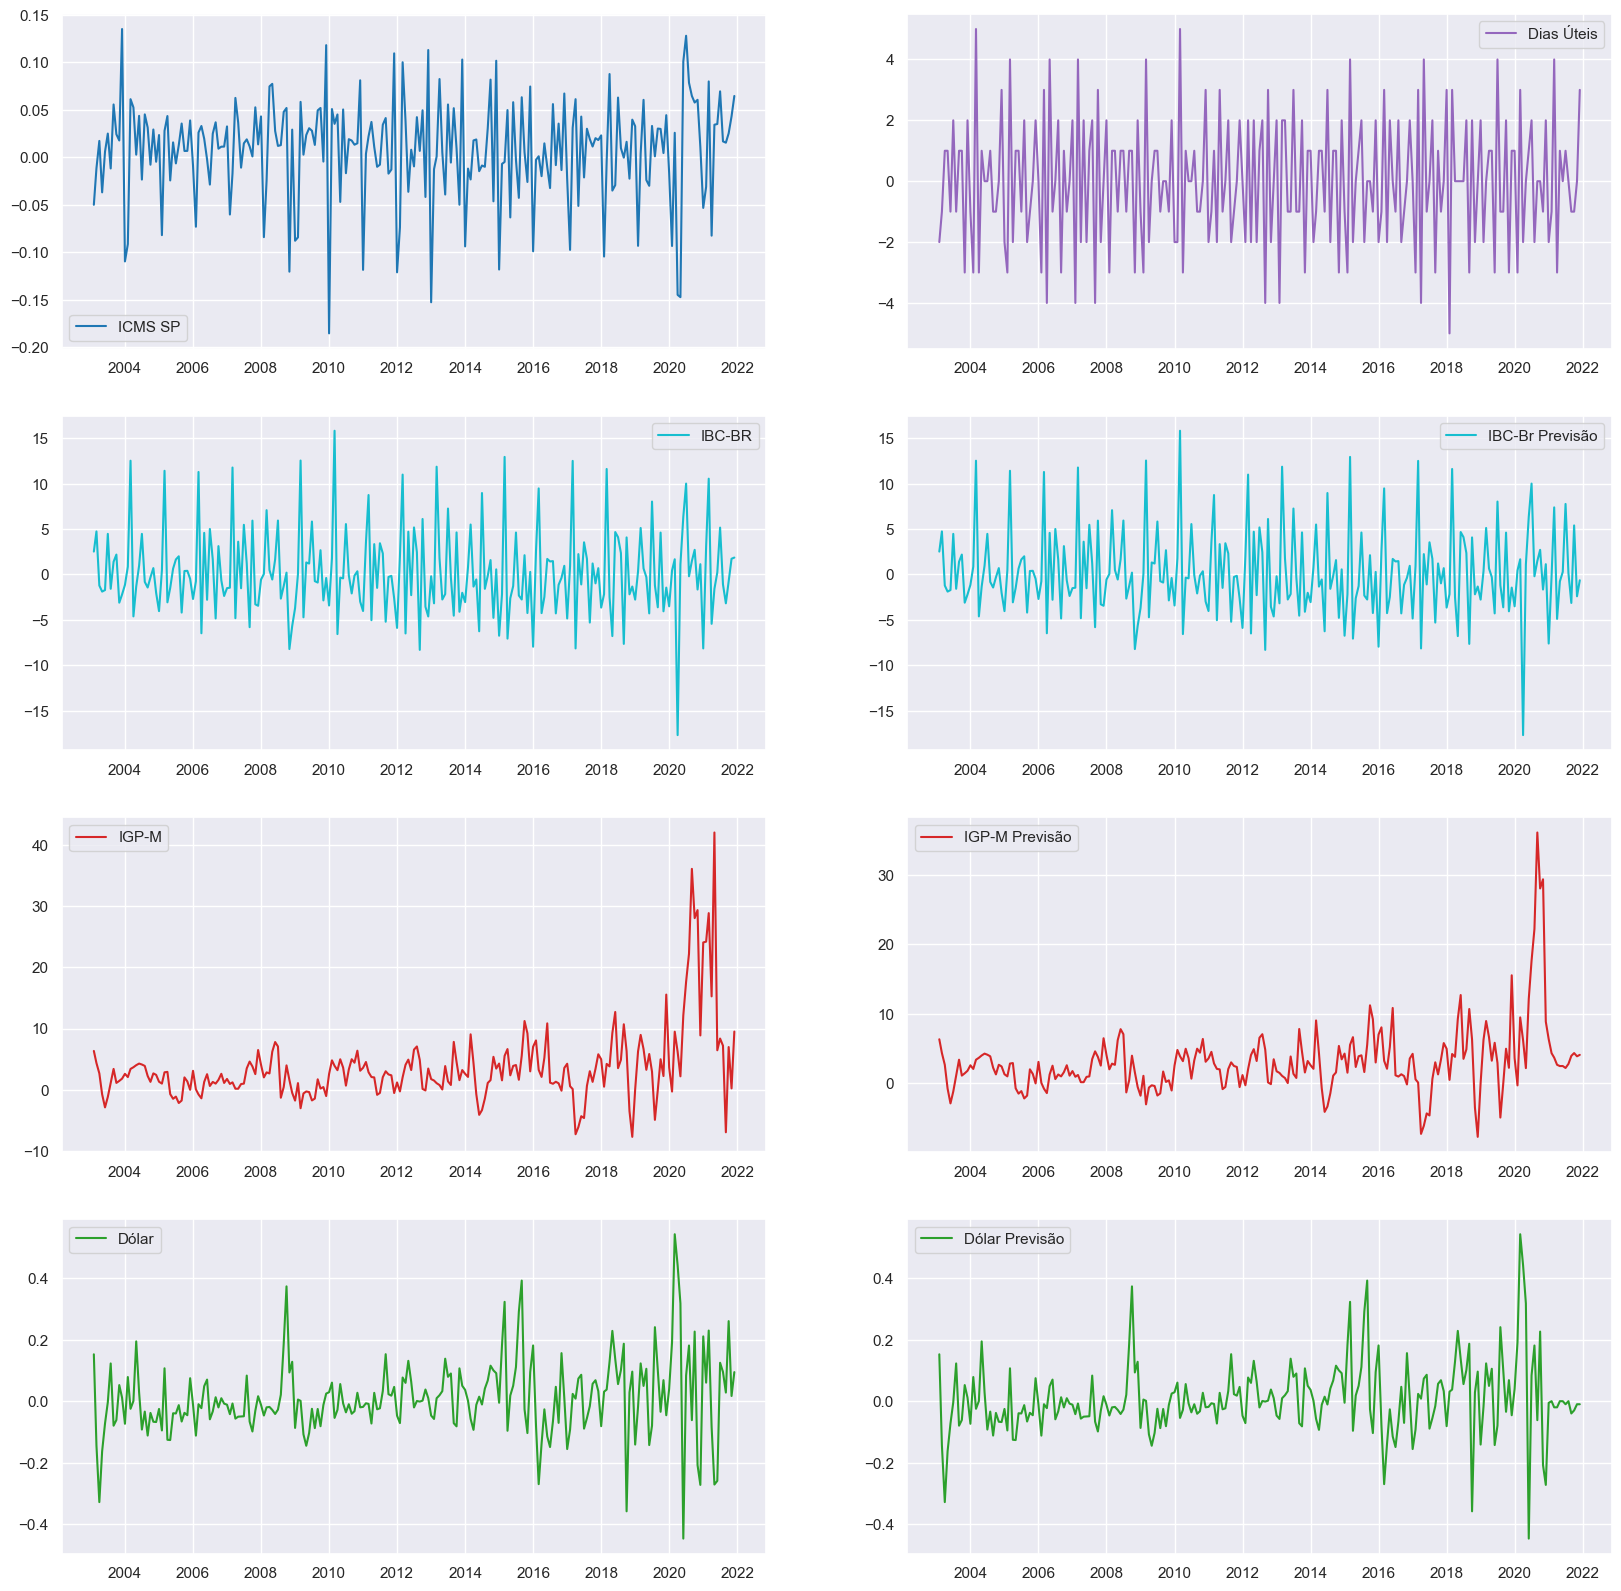

In [13]:
fig=plt.figure(figsize=(20, 20))
ax1=fig.add_subplot(421)
ax2=fig.add_subplot(422)
ax3=fig.add_subplot(423)
ax4=fig.add_subplot(424)
ax5=fig.add_subplot(425)
ax6=fig.add_subplot(426)
ax7=fig.add_subplot(427)
ax8=fig.add_subplot(428)
#plots
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts_d1, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts_d1, 'tab:cyan',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(ibcbr_prev_ts_d1, 'tab:cyan', label='IBC-Br Previsão')
ax4.legend(loc='best')
ax5.plot(igpm_ts_d1, 'tab:red', label='IGP-M')
ax5.legend(loc='best')
ax6.plot(igpm_prev_ts_d1, 'tab:red',  label='IGP-M Previsão')
ax6.legend(loc='best')
ax7.plot(dolar_ts_d1, 'tab:green', label='Dólar')
ax7.legend(loc='best')
ax8.plot(dolar_prev_ts_d1, 'tab:green', label='Dólar Previsão')
ax8.legend(loc='best')
plt.show()

### Plotando as Séries em Segunda Diferença

In [14]:
fig=plt.figure(figsize=(20, 20))
ax1=fig.add_subplot(421)
ax2=fig.add_subplot(422)
ax3=fig.add_subplot(423)
ax4=fig.add_subplot(424)
ax5=fig.add_subplot(425)
ax6=fig.add_subplot(426)
ax7=fig.add_subplot(427)
ax8=fig.add_subplot(428)
#plots
ax1.plot(icms_ts_d2, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts_d2, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts_d2, 'tab:cyan',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(ibcbr_prev_ts_d2, 'tab:cyan', label='IBC-Br Previsão')
ax4.legend(loc='best')
ax5.plot(igpm_ts_d2, 'tab:red', label='IGP-M')
ax5.legend(loc='best')
ax6.plot(igpm_prev_ts_d2, 'tab:red',  label='IGP-M Previsão')
ax6.legend(loc='best')
ax7.plot(dolar_ts_d2, 'tab:green', label='Dólar')
ax7.legend(loc='best')
ax8.plot(dolar_prev_ts_d2, 'tab:green', label='Dólar Previsão')
ax8.legend(loc='best')
plt.show()

### Teste de Raiz Unitária das Séries em Nível

Teste de raiz unitária Dickey-Fuller Aumentado (ADF): a hipótese nula é de que há raiz unitária e a série não é estacionária; a alternativa, de que não há e, portanto, a série é estacionária. 

Teste de raiz unitária Kwiatkowski-Phillips-Schmidt-Shin (KPSS): a hipótese nula é de que a série é de tendência estacionária; a alternativa é de há raiz unitária e a série não é estacionária.

A combinação dos dois testes pode ter os seguintes resultados com as seguintes consequências:

- Caso 1: Ambos os testes concluem que a série não é estacionária, então a série não é estacionária
- Caso 2: Ambos os testes concluem que a série é estacionária, então a série é estacionária
- Caso 3: o KPSS indica estacionariedade e o ADF indica não estacionariedade; a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência deve ser verificada quanto à estacionariedade.
- Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade; a série é estacionária diferencial. A diferenciação deve ser usada para tornar as séries estacionárias. A série diferenciada deve ser verificada quanto à estacionariedade.

**Fonte**: [Statsmodel](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [15]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

#### Série do ICMS

In [16]:
adf_test(icms_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -0.890864
p-value                          0.790966
#Lags Used                      12.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [17]:
kpss_test(icms_ts)

Results of KPSS Test:
Test Statistic           2.275043
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do IBC-Br

In [18]:
adf_test(ibcbr_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.313601
p-value                          0.167619
#Lags Used                      15.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


In [19]:
kpss_test(ibcbr_ts)

Results of KPSS Test:
Test Statistic           1.558092
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IBC-Br em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do IGP-M

In [20]:
adf_test(igpm_ts)

Results of Dickey-Fuller Test:
Test Statistic                   2.771061
p-value                          1.000000
#Lags Used                      13.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [21]:
kpss_test(igpm_ts)

Results of KPSS Test:
Test Statistic           2.175952
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IGP-M em nível: a 5%, não se rejeita a nula do teste ADF e rejeita-se a nula do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do Dólar

In [22]:
adf_test(dolar_ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.925920
p-value                          0.993419
#Lags Used                      14.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


In [23]:
kpss_test(dolar_ts)

Results of KPSS Test:
Test Statistic           1.414523
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do Dólar em nível: a 5%, não se rejeita a nula do teste ADF e rejeita-se a nula do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série Dias Úteis

In [24]:
adf_test(dias_uteis_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -4.141222
p-value                          0.000827
#Lags Used                      14.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


In [25]:
kpss_test(dias_uteis_ts)

Results of KPSS Test:
Test Statistic           0.086253
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série dos Dias Úteis em nível: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em nível.

### Teste de Raiz Unitária da Série em Primeira Diferença
As séries postas em primeira diferença serão testadas para estacionariedade com os testes ADF e KPSS.

#### Série do ICMS

In [26]:
adf_test(icms_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.321049
p-value                          0.000408
#Lags Used                      11.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [27]:
kpss_test(icms_ts_d1)

Results of KPSS Test:
Test Statistic           0.07321
p-value                  0.10000
Lags Used                7.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


Série do ICMS em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

#### Série do IBC-Br

In [28]:
adf_test(ibcbr_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.833250
p-value                          0.002585
#Lags Used                      14.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


In [29]:
kpss_test(ibcbr_ts_d1)

Results of KPSS Test:
Test Statistic            0.310779
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do IBC-Br em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

#### Série do IGP-M

In [30]:
adf_test(igpm_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.961588
p-value                          0.001626
#Lags Used                      12.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [31]:
kpss_test(igpm_ts_d1)

Results of KPSS Test:
Test Statistic           0.672704
p-value                  0.016027
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IGP-M em primeira diferença: a 5%, rejeita-se a nula do teste ADF e também se rejeita a nula do teste KPSS. A série é estacionária pelo teste ADF mas não é estacionária pelo teste KPSS. A série precisa ser diferenciada novamente para poder ser usada.

##### Diferenciando novamente a série e testando a estacionariedade

In [32]:
adf_test(igpm_ts_d2)

Results of Dickey-Fuller Test:
Test Statistic                -5.801737e+00
p-value                        4.614048e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


In [33]:
kpss_test(igpm_ts_d2)

Results of KPSS Test:
Test Statistic            0.04583
p-value                   0.10000
Lags Used                13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


Série do IGP-M em segunda diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em segunda diferença.

#### Série do Dólar

In [34]:
adf_test(dolar_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.549544
p-value                          0.000002
#Lags Used                       4.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


In [35]:
kpss_test(dolar_ts_d1)

Results of KPSS Test:
Test Statistic           0.762196
p-value                  0.010000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do Dólar em primeira diferença: a 5%, rejeita-se a nula do teste ADF e também se rejeita a nula do teste KPSS. A série é estacionária pelo teste ADF mas não é estacionária pelo teste KPSS. A série precisa ser diferenciada novamente para poder ser usada.

##### Diferenciando novamente a série e testando a estacionariedade

In [36]:
dolar_ts_d2 = dolar_ts_d1.diff().dropna()

In [37]:
adf_test(dolar_ts_d2)

Results of Dickey-Fuller Test:
Test Statistic                -6.443290e+00
p-value                        1.588477e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


In [38]:
kpss_test(dolar_ts_d2)

Results of KPSS Test:
Test Statistic            0.132405
p-value                   0.100000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do Dólar em segunda diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em segunda diferença.

#### Série Dias Úteis

Não será testada, pois já é estacionária em nível.

### Estacionariedade das Séries

Conclue-se que, para se trabalhar com todas as séries estacionárias, as séries serão usadas em nível, em primeira ou segunda diferença, conforme abaixo:
- ICMS: primeira diferença
- IBC-Br: primeira diferença
- IGP-M: segunda diferença
- Dólar: segunda diferença
- Dias Úteis: nível

##### Equalizando o tamanho das séries
IPCA e Dias Úteis ficaram maiores que as demais séries estão em nível, assim como as séries em primeira diferenças estão maiores do que as em segunda diferença. O primeiro e o segundo valores destas duas séries, e somente o primeiro das que estão em primeira diferança serão removidos.

In [39]:
print('antes', icms_ts_d1.shape, ibcbr_ts_d1.shape, igpm_ts_d2.shape, dolar_ts_d2.shape, dias_uteis_ts.shape,
     ibcbr_prev_ts_d1.shape, igpm_prev_ts_d2.shape, dolar_prev_ts_d2.shape,)
icms_ts_adj = icms_ts_d1[1:]
ibcbr_ts_adj = ibcbr_ts_d1[1:]
igpm_ts_adj = igpm_ts_d2
dolar_ts_adj = dolar_ts_d2
dias_uteis_ts_adj = dias_uteis_ts[2:]
ibcbr_prev_ts_adj = ibcbr_prev_ts_d1[1:]
igpm_prev_ts_adj = igpm_prev_ts_d2
dolar_prev_ts_adj = dolar_prev_ts_d2
print('depois', icms_ts_adj.shape, ibcbr_ts_adj.shape, igpm_ts_adj.shape, dolar_ts_adj.shape, 
      dias_uteis_ts_adj.shape, ibcbr_prev_ts_adj.shape, igpm_prev_ts_adj.shape, dolar_prev_ts_adj.shape)

antes (227,) (227,) (226,) (226,) (228,) (227,) (226,) (226,)
depois (226,) (226,) (226,) (226,) (226,) (226,) (226,) (226,)


### Dessazonalização das Séries

In [40]:
sns.set(rc={'figure.figsize':(15,8)})

#### Série do ICMS

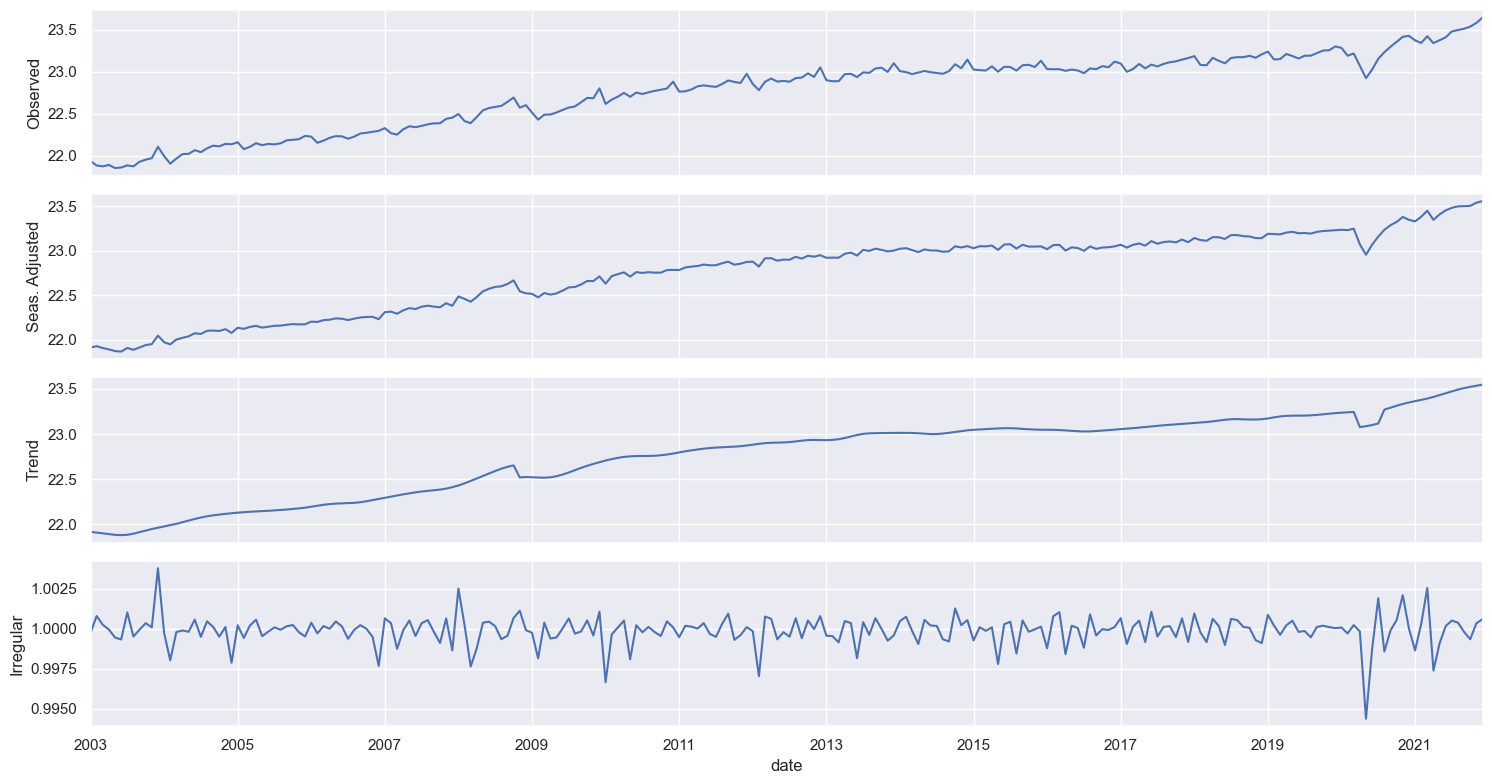

In [41]:
seas_icms = statsmodels.tsa.x13.x13_arima_analysis(icms_ts, x12path='./x13asmac/')
plot = seas_icms.plot()

In [42]:
icms_decomp = pd.DataFrame(data={'ICMS observado': seas_icms.observed, 
                                 'ICMS desazonalizado': seas_icms.seasadj})
plot = icms_decomp.plot(title='Arrecadação Mensal do ICMS')

#### Série do IBC-Br

In [43]:
sns.set(rc={'figure.figsize':(15,8)})
seas_ibcbr = statsmodels.tsa.x13.x13_arima_analysis(ibcbr_ts, x12path='./x13asmac/')
plot = seas_ibcbr.plot()

In [44]:
sns.set(rc={'figure.figsize':(15,4)})
ibcbr_decomp = pd.DataFrame(data={'IBC-Br observado': seas_ibcbr.observed, 
                                  'IBC desazonalizado': seas_ibcbr.seasadj})
plot = ibcbr_decomp.plot(title='Série Mensal do IBC-Br')

#### Série do IGP-DI

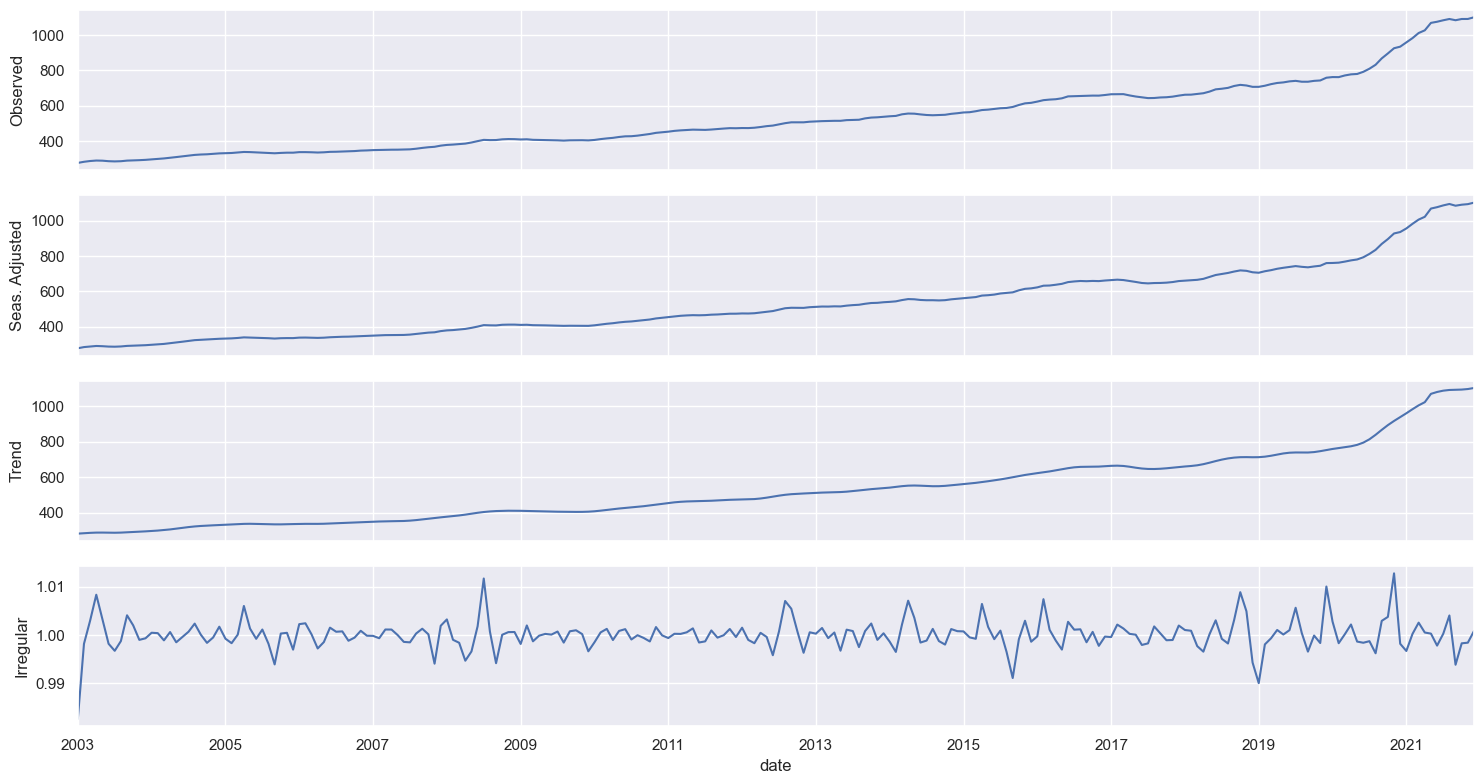

In [45]:
sns.set(rc={'figure.figsize':(15,8)})
seas_igpm = statsmodels.tsa.x13.x13_arima_analysis(igpm_ts, x12path='./x13asmac/')
plot = seas_igpm.plot()

In [46]:
sns.set(rc={'figure.figsize':(15,4)})
igpm_decomp = pd.DataFrame(data={'IGP-M observado': seas_igpm.observed, 
                                  'IGP-M desazonalizado': seas_igpm.seasadj})
plot = igpm_decomp.plot(title='Série Mensal do IGP-M')

#### Série do Dólar

In [47]:
sns.set(rc={'figure.figsize':(15,8)})
seas_dolar = statsmodels.tsa.x13.x13_arima_analysis(dolar_ts, x12path='./x13asmac/')
plot = seas_dolar.plot()

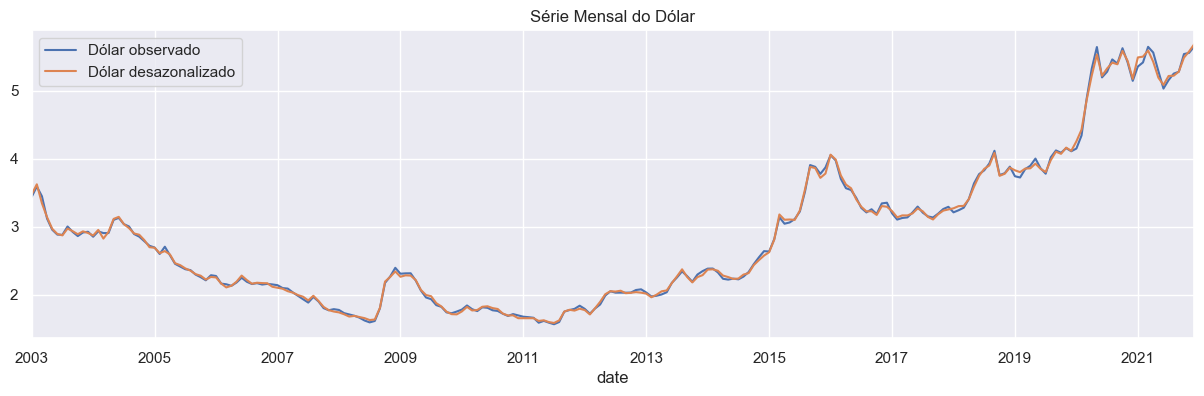

In [48]:
sns.set(rc={'figure.figsize':(15,4)})
dolar_decomp = pd.DataFrame(data={'Dólar observado': seas_dolar.observed, 
                                  'Dólar desazonalizado': seas_dolar.seasadj})
plot = dolar_decomp.plot(title='Série Mensal do Dólar')

#### Série dos Dias Úteis

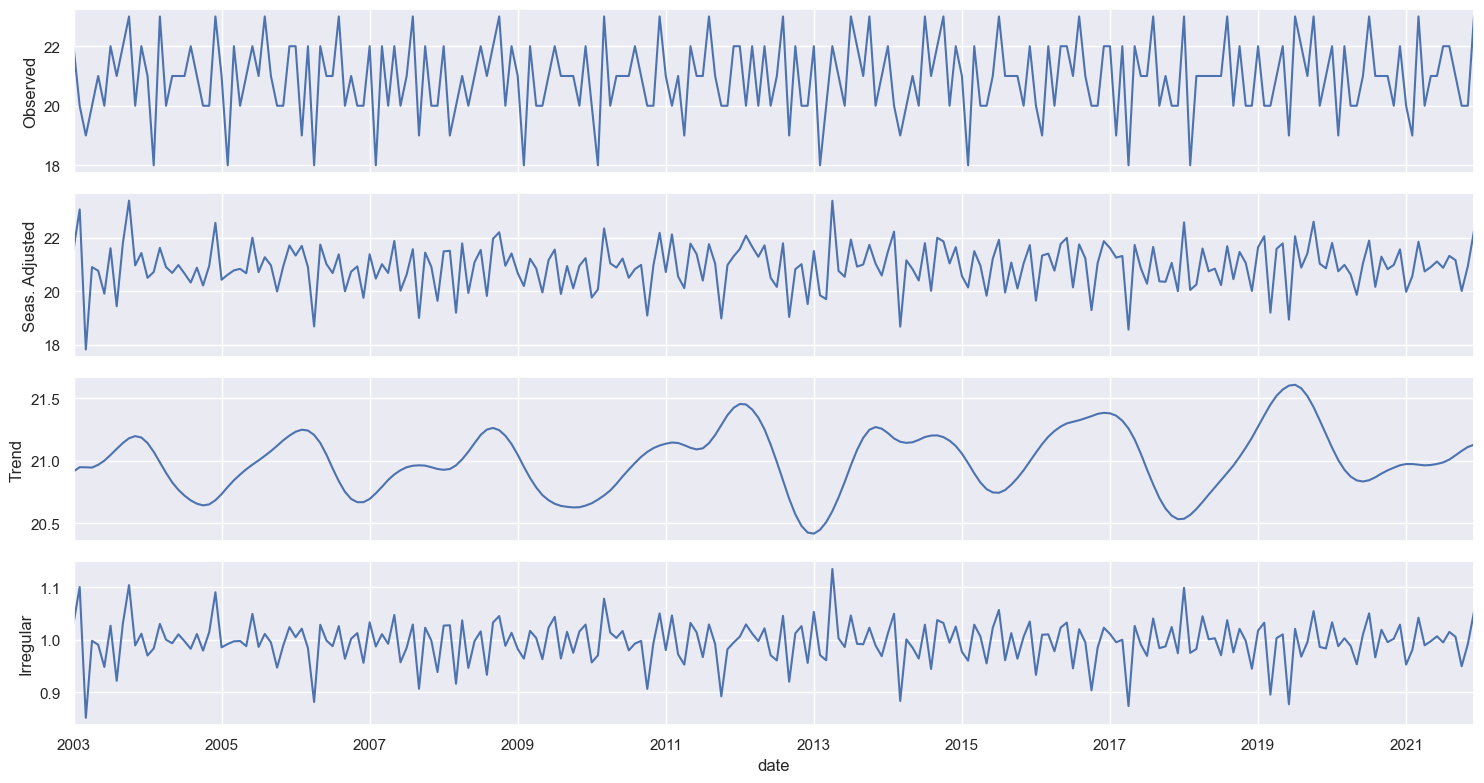

In [49]:
sns.set(rc={'figure.figsize':(15,8)})
seas_dias_uteis = statsmodels.tsa.x13.x13_arima_analysis(dias_uteis_ts, x12path='./x13asmac/')
plot = seas_dias_uteis.plot()

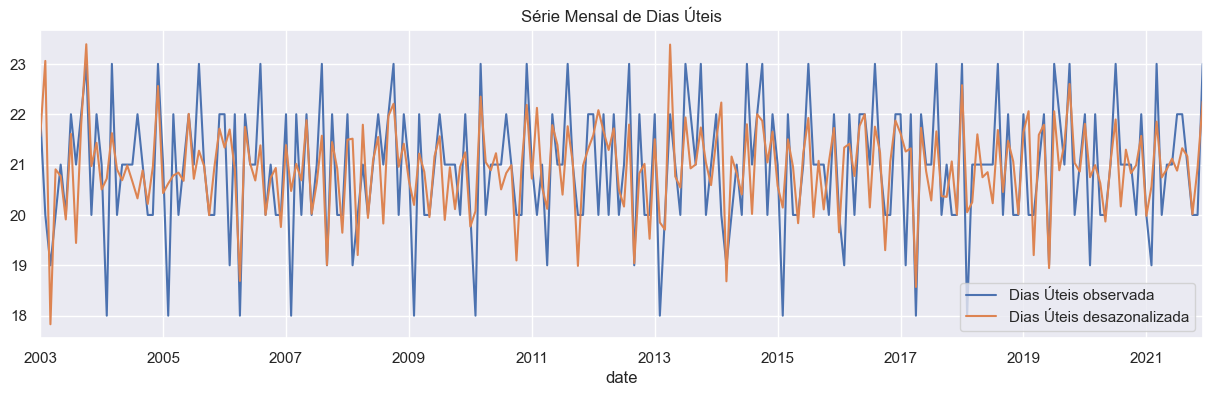

In [50]:
sns.set(rc={'figure.figsize':(15,4)})
dias_uteis_decomp = pd.DataFrame(data={'Dias Úteis observada': seas_dias_uteis.observed, 
                                  'Dias Úteis desazonalizada': seas_dias_uteis.seasadj})
plot = dias_uteis_decomp.plot(title='Série Mensal de Dias Úteis')

In [51]:
sns.set(rc={'figure.figsize':(15,8)})

### Criando dummies de intervenção

In [52]:
pos = seas_icms.results.find('Outliers')
print(seas_icms.results[pos-309:pos+2105])

 ------------------------------------------------------------------------------
                             Parameter        Standard
 Variable                     Estimate           Error      t-value
 ------------------------------------------------------------------------------
 Automatically Identified Outliers
   LS2008.Nov                  -0.0063         0.00114        -5.58
   LS2020.Apr                  -0.0075         0.00121        -6.19
   AO2020.May                  -0.0059         0.00125        -4.73
   LS2020.Aug                   0.0057         0.00116         4.96
 ------------------------------------------------------------------------------


 ARIMA Model:  (2 1 0)(1 1 1)
   Nonseasonal differences: 1
   Seasonal differences:    1
                                              Standard
 Parameter                    Estimate          Errors
 -----------------------------------------------------
 Nonseasonal AR                                    
   Lag  1            

In [53]:
ls2008nov = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
dt_final = str(ls2008nov.index[-1])

ls2008nov['2008-11-01':dt_final] = 1
ls2020abr = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020abr['2020-04-01':dt_final ] = 1
ao2020mai = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ao2020mai['2020-05-01'] = 1
ls2020ago = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020ago['2020-08-01':dt_final ] = 1

In [54]:
ls2008nov.shape, ls2020abr.shape, ao2020mai.shape, ls2020ago.shape

((228,), (228,), (228,), (228,))

### Testes de Causalidade de Granger
Verificando quais das séries causam ICMS para que possam ser usadas como exógenas nos modelos.

#### Verificando se IBC-Br granger causa ICMS

In [55]:
gt_data = pd.DataFrame({'ibcbr':list(seas_ibcbr.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4948  , p=0.2228  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=1.5148  , p=0.2184  , df=1
likelihood ratio test: chi2=1.5098  , p=0.2192  , df=1
parameter F test:         F=1.4948  , p=0.2228  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2065  , p=0.8136  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=0.4224  , p=0.8096  , df=2
likelihood ratio test: chi2=0.4220  , p=0.8098  , df=2
parameter F test:         F=0.2065  , p=0.8136  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9997  , p=0.3939  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=3.0953  , p=0.3772  , df=3
likelihood ratio test: chi2=3.0742  , p=0.3803  , df=3
parameter F test:         F=0.9997  , p=0.3939  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9174  , p=0.1086  

{1: ({'ssr_ftest': (1.4948131453651752, 0.2227560069523679, 224.0, 1),
   'ssr_chi2test': (1.5148329642763159, 0.21840309746700715, 1),
   'lrtest': (1.5098008918619144, 0.2191694710202176, 1),
   'params_ftest': (1.494813145365407, 0.22275600695232425, 224.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.2065097978673991, 0.8135750765282183, 221.0, 2),
   'ssr_chi2test': (0.4223639304799294, 0.8096267295544217, 2),
   'lrtest': (0.4219697505216118, 0.8097863145954656, 2),
   'params_ftest': (0.20650979786765133, 0.8135750765280082, 221.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.9996538011583068, 0.3938923183894628, 218.0, 3),
   'ssr_chi2test': (3.0952583292745737, 0.3771701291569958, 3),
   'lrtest': (3.0741613168124786, 0.38033169661453275, 3),
   'params_ftest': (0.999653801158196, 0.3938923183895122, 218.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

A 5%, IBC-Br granger causa ICMS no lag 7.

#### Verificando se IGP-M granger causa ICMS

In [56]:
gt_data = pd.DataFrame({'igpm':list(seas_igpm.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1082  , p=0.0028  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=9.2302  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0475  , p=0.0026  , df=1
parameter F test:         F=9.1082  , p=0.0028  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7686  , p=0.4649  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=1.5720  , p=0.4557  , df=2
likelihood ratio test: chi2=1.5666  , p=0.4569  , df=2
parameter F test:         F=0.7686  , p=0.4649  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3646  , p=0.2545  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=4.2251  , p=0.2382  , df=3
likelihood ratio test: chi2=4.1859  , p=0.2421  , df=3
parameter F test:         F=1.3646  , p=0.2545  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9875  , p=0.4153  

{1: ({'ssr_ftest': (9.108190605167406, 0.0028391696539057515, 224.0, 1),
   'ssr_chi2test': (9.230175300772327, 0.002380588542884118, 1),
   'lrtest': (9.047455305250423, 0.0026306070549713192, 1),
   'params_ftest': (9.108190605167405, 0.0028391696539057515, 224.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.7686207426961126, 0.4648874843958235, 221.0, 2),
   'ssr_chi2test': (1.5720207045187462, 0.45565909294217133, 2),
   'lrtest': (1.5665785611549836, 0.45690066243028327, 2),
   'params_ftest': (0.768620742696575, 0.464887484395611, 221.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.3645564655750642, 0.2545326512178075, 218.0, 3),
   'ssr_chi2test': (4.2251174966200375, 0.23815914810542352, 3),
   'lrtest': (4.185936970528928, 0.24207363792223782, 3),
   'params_ftest': (1.364556465574769, 0.25453265121790236, 218.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

A 5%, IGP-DI granger causa ICMS a partir do lag 6.

#### Verificando se Dólar granger causa ICMS

In [57]:
gt_data = pd.DataFrame({'dolar':list(seas_dolar.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4458 , p=0.0003  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=13.6259 , p=0.0002  , df=1
likelihood ratio test: chi2=13.2326 , p=0.0003  , df=1
parameter F test:         F=13.4458 , p=0.0003  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6860  , p=0.0039  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=11.6293 , p=0.0030  , df=2
likelihood ratio test: chi2=11.3400 , p=0.0034  , df=2
parameter F test:         F=5.6860  , p=0.0039  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8274  , p=0.0106  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=11.8510 , p=0.0079  , df=3
likelihood ratio test: chi2=11.5494 , p=0.0091  , df=3
parameter F test:         F=3.8274  , p=0.0106  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4778  , p=0.0089  

{1: ({'ssr_ftest': (13.445783418885094, 0.0003067503095227096, 224.0, 1),
   'ssr_chi2test': (13.62586087538802, 0.00022309116680069099, 1),
   'lrtest': (13.2325712045307, 0.0002751261448671238, 1),
   'params_ftest': (13.445783418884862, 0.0003067503095227482, 224.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.686013109138334, 0.00390869134710173, 221.0, 2),
   'ssr_chi2test': (11.62931187932365, 0.0029835066572112493, 2),
   'lrtest': (11.339990045199556, 0.0034478824375512255, 2),
   'params_ftest': (5.686013109138162, 0.003908691347102378, 221.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.827436901594944, 0.010615187941557308, 218.0, 3),
   'ssr_chi2test': (11.851008754938473, 0.007911364513689227, 3),
   'lrtest': (11.549449395409738, 0.00909725778413538, 3),
   'params_ftest': (3.8274369015954286, 0.01061518794155045, 218.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
  

A 5%, Dólar granger causa ICMS no a partir do lag 1.

#### Verificando se Dias Úteis granger causa ICMS

In [58]:
gt_data = pd.DataFrame({'dias_uteis':list(seas_dias_uteis.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7895  , p=0.3752  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=0.8000  , p=0.3711  , df=1
likelihood ratio test: chi2=0.7986  , p=0.3715  , df=1
parameter F test:         F=0.7895  , p=0.3752  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8587  , p=0.1583  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=3.8015  , p=0.1495  , df=2
likelihood ratio test: chi2=3.7699  , p=0.1518  , df=2
parameter F test:         F=1.8587  , p=0.1583  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1706  , p=0.3218  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=3.6246  , p=0.3050  , df=3
likelihood ratio test: chi2=3.5958  , p=0.3086  , df=3
parameter F test:         F=1.1706  , p=0.3218  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8679  , p=0.1172  

{1: ({'ssr_ftest': (0.7894574201690946, 0.37521735352117636, 224.0, 1),
   'ssr_chi2test': (0.8000305106177878, 0.37108424750673985, 1),
   'lrtest': (0.7986240151581114, 0.3715050850252206, 1),
   'params_ftest': (0.7894574201686473, 0.37521735352132013, 224.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.8587077213037817, 0.1583023784055321, 221.0, 2),
   'ssr_chi2test': (3.8015198643860155, 0.14945500039059603, 2),
   'lrtest': (3.7699014749611024, 0.15183653909565575, 2),
   'params_ftest': (1.858707721303217, 0.15830237840562086, 221.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.1706253700467182, 0.3218202130591068, 218.0, 3),
   'ssr_chi2test': (3.6246427742272234, 0.304952525885372, 3),
   'lrtest': (3.595756951989756, 0.3085534741114755, 3),
   'params_ftest': (1.1706253700464775, 0.32182021305919195, 218.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

A 5%, Dias Úteis granger causa ICMS no lag 10.

#### Resumos dos testes de causalidade

- IBC-Br: granger causa no lag 7.
- IGP-DI: granger causa a partir do lag 6.
- Dólar: granger causa a partir do lag 1.
- Dias Úteis: granger causa a partir do lag 10.

## Preparação para Previsões

O artigo usa, além de MAPE e MSE, o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [59]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões

In [60]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos SARIMAX com variáveis exógenas
As previsões do IBC-Br, IGP-M e Dólar foram obtidas no Sistema de Expectativas de Mercado do Bacen em 27/12/2021. Cada uma das previsões com as variáveis previstas será comparada com as variáveis reais.

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Serão usadas as séries com sazonalidade e em nível e as questões de sazonalidade e estacionariedade serão tratadas pelo modelo.

In [61]:
exog_df = pd.DataFrame((ibcbr_prev_ts, igpm_prev_ts,
                        dolar_prev_ts, dias_uteis_ts, ls2008nov, 
                        ls2020abr, ao2020mai, ls2020ago
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis',
                               'ls2008nov','ls2020abr', 'ao2020mai','ls2020ago'
                            ]).transpose()
exog_df.head() 

ibcbr    igpdi   dolar  dias_uteis  ls2008nov  ls2020abr  \
2003-01-01   96.15  277.173  3.4384        22.0        0.0        0.0   
2003-02-01   98.67  283.506  3.5908        20.0        0.0        0.0   
2003-03-01  103.41  287.855  3.4469        19.0        0.0        0.0   
2003-04-01  102.19  290.512  3.1187        20.0        0.0        0.0   
2003-05-01  100.30  289.747  2.9557        21.0        0.0        0.0   

            ao2020mai  ls2020ago  
2003-01-01        0.0        0.0  
2003-02-01        0.0        0.0  
2003-03-01        0.0        0.0  
2003-04-01        0.0        0.0  
2003-05-01        0.0        0.0

In [62]:
exog_df.tail() 

ibcbr       igpdi  dolar  dias_uteis  ls2008nov  ls2020abr  \
2021-08-01  141.407051  961.725459   5.09        22.0        1.0        1.0   
2021-09-01  138.268439  965.668534   5.05        21.0        1.0        1.0   
2021-10-01  143.670010  970.014042   5.02        20.0        1.0        1.0   
2021-11-01  141.263632  973.894098   5.01        20.0        1.0        1.0   
2021-12-01  140.620558  977.984454   5.00        23.0        1.0        1.0   

            ao2020mai  ls2020ago  
2021-08-01        0.0        1.0  
2021-09-01        0.0        1.0  
2021-10-01        0.0        1.0  
2021-11-01        0.0        1.0  
2021-12-01        0.0        1.0

In [63]:
exog = exog_df[:].to_numpy()
exog_train = exog[:-12]
exog_test = exog[-12:]
print(exog.shape, exog_train.shape, exog_test.shape)

(228, 8) (216, 8) (12, 8)


In [64]:
icms_train = icms_ts[:-12]
icms_test = np.exp(icms_ts[-12:]) # série sem log
print(icms_ts.shape, icms_train.shape, icms_test.shape)

(228,) (216,) (12,)


In [65]:
exog_reais_df = pd.DataFrame((ibcbr_ts, igpm_ts,
                        dolar_ts, dias_uteis_ts, ls2008nov, 
                        ls2020abr, ao2020mai, ls2020ago
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis',
                               'ls2008nov','ls2020abr', 'ao2020mai','ls2020ago'
                            ]).transpose()
exog_reais_df.head() 

ibcbr    igpdi   dolar  dias_uteis  ls2008nov  ls2020abr  \
2003-01-01   96.15  277.173  3.4384        22.0        0.0        0.0   
2003-02-01   98.67  283.506  3.5908        20.0        0.0        0.0   
2003-03-01  103.41  287.855  3.4469        19.0        0.0        0.0   
2003-04-01  102.19  290.512  3.1187        20.0        0.0        0.0   
2003-05-01  100.30  289.747  2.9557        21.0        0.0        0.0   

            ao2020mai  ls2020ago  
2003-01-01        0.0        0.0  
2003-02-01        0.0        0.0  
2003-03-01        0.0        0.0  
2003-04-01        0.0        0.0  
2003-05-01        0.0        0.0

In [66]:
exog_reais_df.tail() 

ibcbr     igpdi     dolar  dias_uteis  ls2008nov  ls2020abr  \
2021-08-01  141.97  1091.290  5.251718        22.0        1.0        1.0   
2021-09-01  138.79  1084.312  5.279690        21.0        1.0        1.0   
2021-10-01  138.02  1091.283  5.539980        20.0        1.0        1.0   
2021-11-01  139.75  1091.483  5.556860        20.0        1.0        1.0   
2021-12-01  141.61  1100.988  5.651391        23.0        1.0        1.0   

            ao2020mai  ls2020ago  
2021-08-01        0.0        1.0  
2021-09-01        0.0        1.0  
2021-10-01        0.0        1.0  
2021-11-01        0.0        1.0  
2021-12-01        0.0        1.0

In [67]:
exog_reais = exog_reais_df[:].to_numpy()
exog_reais_test = exog_reais[-12:]
print(exog_reais.shape, exog_reais_test.shape)

(228, 8) (12, 8)


### Auto Arima da Série

#### Critério de Akaike

In [68]:
mod_aa_aic = auto_arima(y=icms_train, x=exog_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [69]:
mod_aa_bic = auto_arima(y=icms_train, x=exog_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='bic')
mod_aa_bic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMAX(1,1,1)(2,0,1) sugerido pelo critério de Akaike

In [70]:
mod_arima1 = ARIMA(endog=icms_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(2, 0, 1, 12))
res_arima1 = mod_arima1.fit()
print(res_arima1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  216
Model:             ARIMA(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 432.732
Date:                          Sun, 20 Aug 2023   AIC                           -837.464
Time:                                  16:45:50   BIC                           -790.275
Sample:                              01-01-2003   HQIC                          -818.397
                                   - 12-01-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0012      0.001      0.806      0.420      -0.002       0.004
x2             0.0008      0.000      2.925      0.

#### Análise dos Resíduos

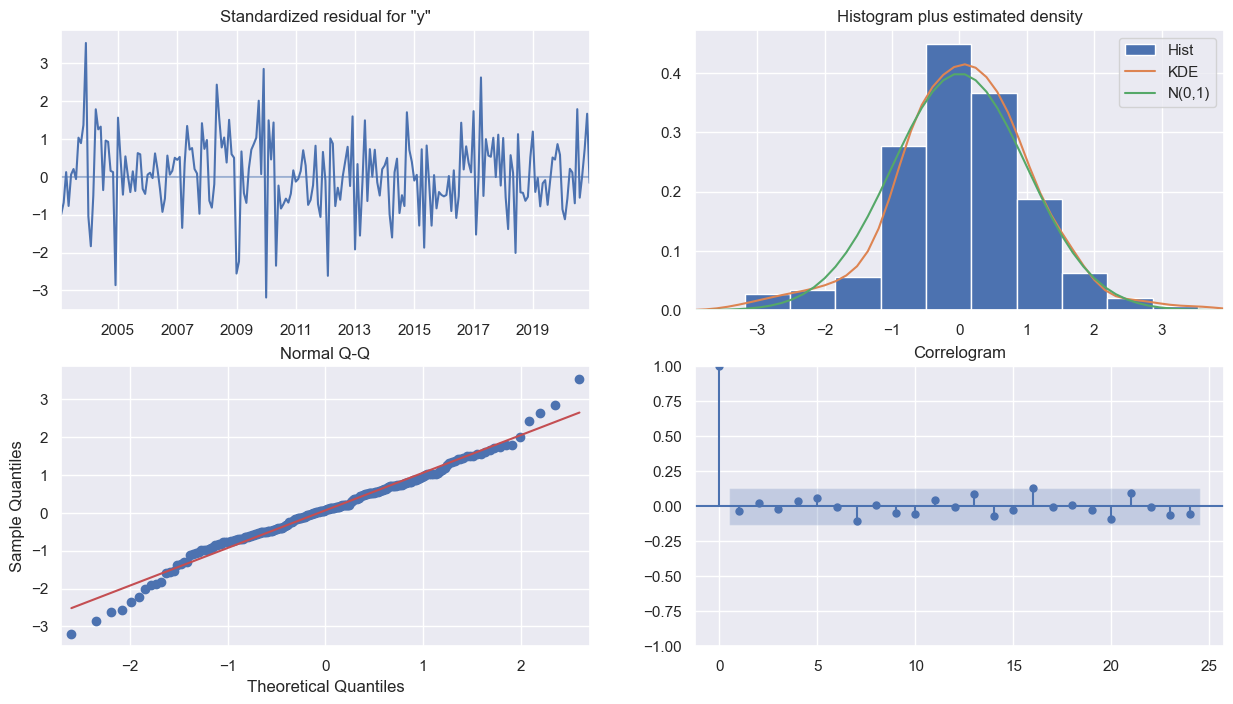

In [71]:
ax = res_arima1.plot_diagnostics(lags=24)

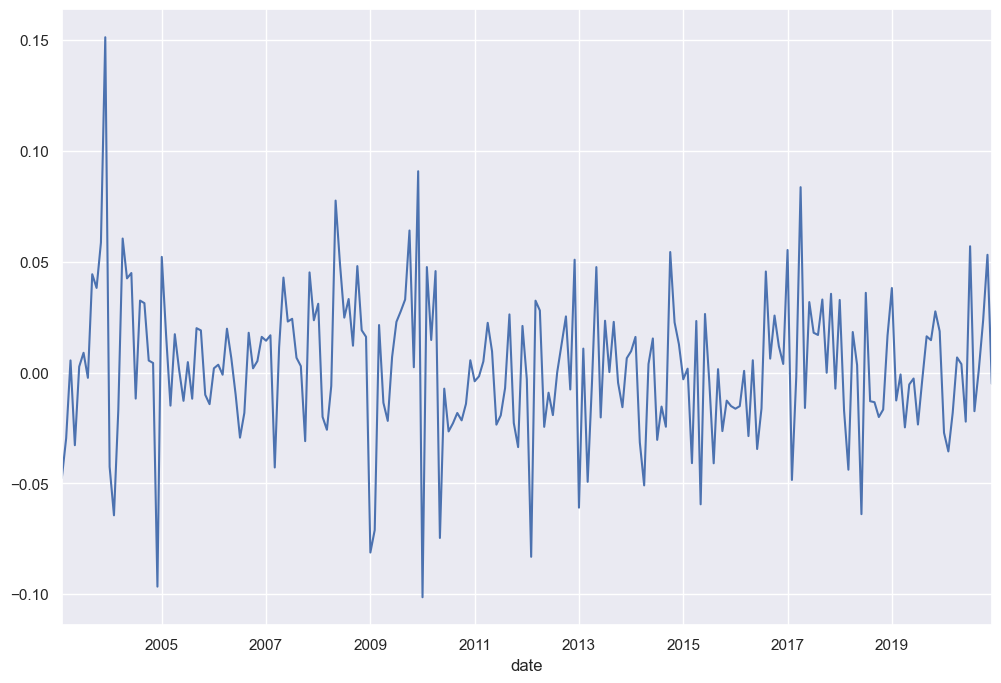

In [72]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima1.resid[1:].plot(ax=ax)

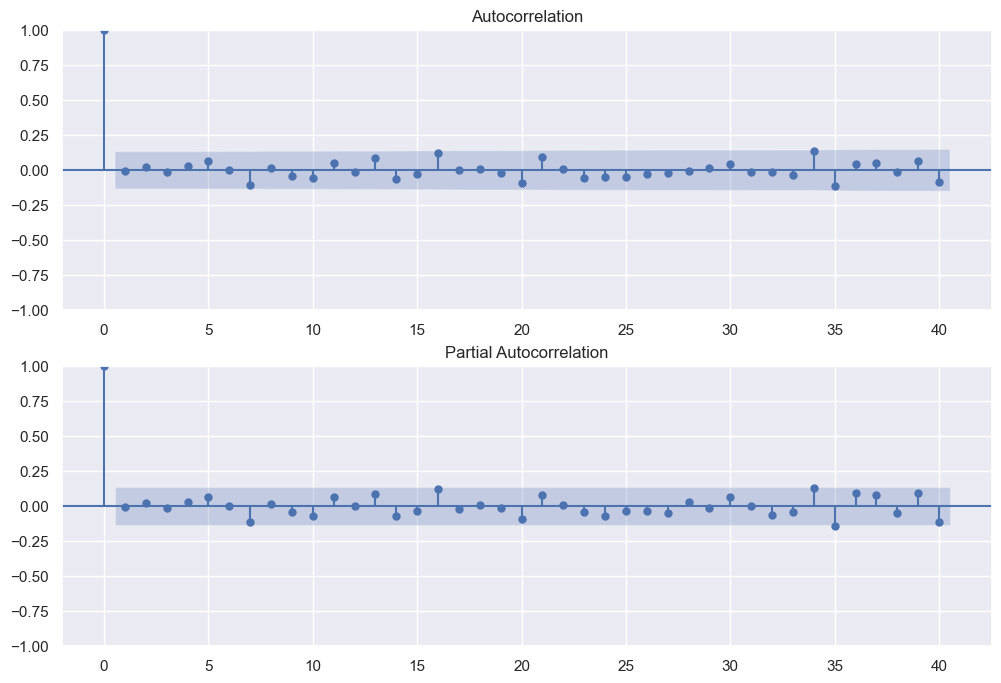

In [73]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima1.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima1.resid[1:], lags=40, ax=ax2)

In [74]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima1.resid[1:], line="q", ax=ax, fit=True)

#### Previsões com Exógenas Previstas

In [75]:
previsoes['nome'].append('SARIMAX(1,1,1)(2,0,1)')
previsoes['modelo'].append(res_arima1)

In [76]:
y_arima1_pred = np.exp(res_arima1.forecast(12, exog=exog_test))
previsoes['previsoes'].append(y_arima1_pred)
y_arima1_pred

2021-01-01    1.468288e+10
2021-02-01    1.377577e+10
2021-03-01    1.417012e+10
2021-04-01    1.435768e+10
2021-05-01    1.413912e+10
2021-06-01    1.392085e+10
2021-07-01    1.463716e+10
2021-08-01    1.441280e+10
2021-09-01    1.467932e+10
2021-10-01    1.488712e+10
2021-11-01    1.535108e+10
2021-12-01    1.584315e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [77]:
RMSE_arima1 = mean_squared_error(icms_test, y_arima1_pred, squared=False)
previsoes['rmse'].append(RMSE_arima1)
RMSE_arima1

1359679576.6110208

In [78]:
MAPE_arima1 = mean_absolute_percentage_error(icms_test, y_arima1_pred)
previsoes['mape'].append(MAPE_arima1)
MAPE_arima1

0.06825553054657041

In [79]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima1_pred, icms_test)])

#### Previsões com Exógenas Reais

In [80]:
previsoes['nome'].append('SARIMAX(1,1,1),(2,0,1) Real')
previsoes['modelo'].append(None)

In [81]:
y_arima3_pred = np.exp(res_arima1.forecast(12, exog=exog_reais_test))
previsoes['previsoes'].append(y_arima3_pred)
y_arima3_pred

2021-01-01    1.498258e+10
2021-02-01    1.437103e+10
2021-03-01    1.525976e+10
2021-04-01    1.558621e+10
2021-05-01    1.572612e+10
2021-06-01    1.541996e+10
2021-07-01    1.630797e+10
2021-08-01    1.613617e+10
2021-09-01    1.631654e+10
2021-10-01    1.659740e+10
2021-11-01    1.715999e+10
2021-12-01    1.789604e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [82]:
RMSE_arima3 = mean_squared_error(icms_test, y_arima3_pred, squared=False)
previsoes['rmse'].append(RMSE_arima3)
RMSE_arima3

864199006.3721322

In [83]:
MAPE_arima3 = mean_absolute_percentage_error(icms_test, y_arima3_pred)
previsoes['mape'].append(MAPE_arima3)
MAPE_arima3

0.045414685891311424

In [84]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima3_pred, icms_test)])

### Modelo SARIMAX(0,1,1),(1,0,1) sugerido pelo critério de Schwartz

In [85]:
mod_arima2 = ARIMA(endog=icms_train, exog=exog_train, order=(0, 1, 1), seasonal_order=(1, 0, 1, 12))
res_arima2 = mod_arima2.fit()
print(res_arima2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  216
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 429.351
Date:                          Sun, 20 Aug 2023   AIC                           -834.701
Time:                                  16:45:59   BIC                           -794.254
Sample:                              01-01-2003   HQIC                          -818.359
                                   - 12-01-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.001      0.387      0.699      -0.002       0.003
x2             0.0008      0.000      2.608      0.

#### Análise dos Resíduos

In [86]:
ax = res_arima2.plot_diagnostics(lags=24)

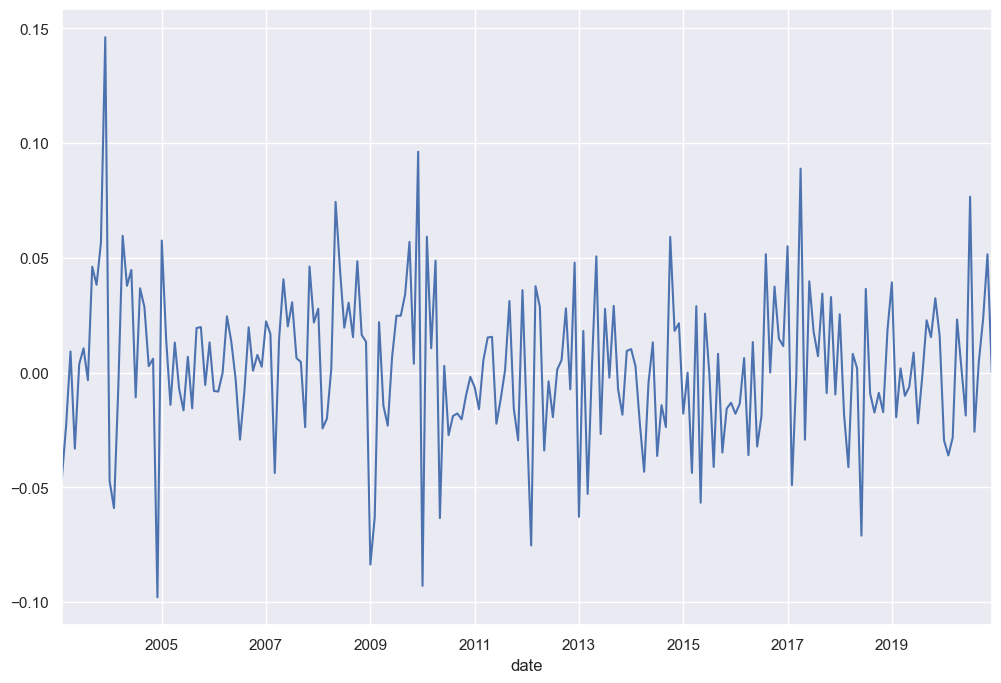

In [87]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima2.resid[1:].plot(ax=ax)

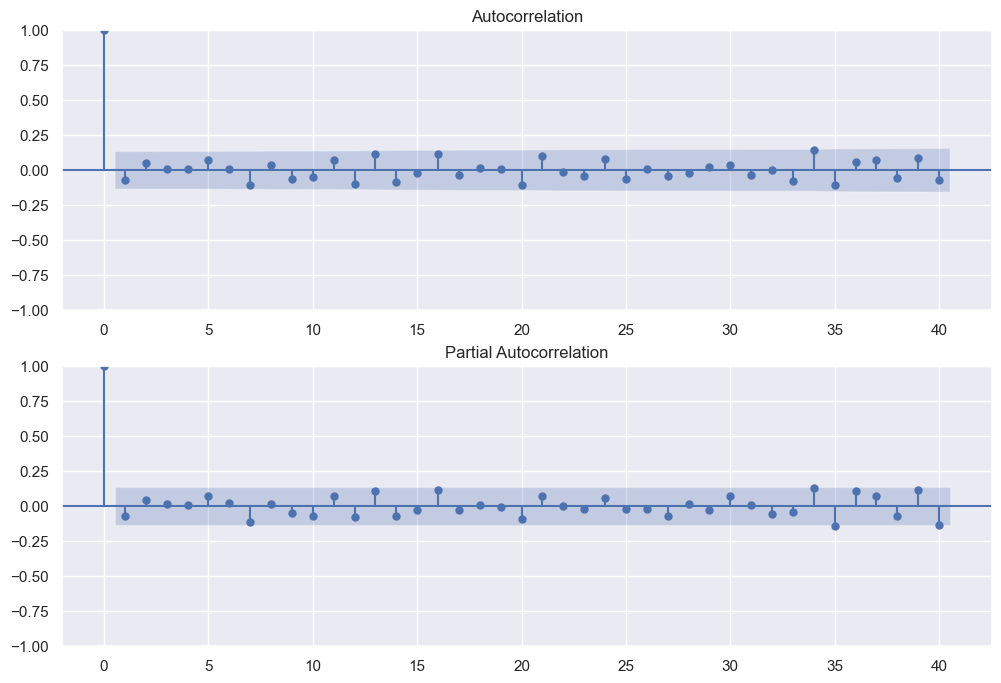

In [88]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima2.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima2.resid[1:], lags=40, ax=ax2)

In [89]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima2.resid[1:], line="q", ax=ax, fit=True)

#### Previsões com Exógenas Previstas

In [90]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima2)

In [91]:
y_arima2_pred = np.exp(res_arima2.forecast(12, exog=exog_test))
previsoes['previsoes'].append(y_arima2_pred)
y_arima2_pred

2021-01-01    1.453891e+10
2021-02-01    1.370487e+10
2021-03-01    1.400290e+10
2021-04-01    1.437355e+10
2021-05-01    1.411393e+10
2021-06-01    1.392125e+10
2021-07-01    1.481646e+10
2021-08-01    1.440419e+10
2021-09-01    1.467515e+10
2021-10-01    1.488197e+10
2021-11-01    1.537438e+10
2021-12-01    1.582923e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [92]:
RMSE_arima2 = mean_squared_error(icms_test, y_arima2_pred, squared=False)
previsoes['rmse'].append(RMSE_arima2)
RMSE_arima2

1354151378.3238428

In [93]:
MAPE_arima2 = mean_absolute_percentage_error(icms_test, y_arima2_pred)
previsoes['mape'].append(MAPE_arima2)
MAPE_arima2

0.06724885698854628

In [94]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima2_pred, icms_test)])

#### Previsões com as Exógenas Reais

In [95]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1) Real')
previsoes['modelo'].append(None)

In [96]:
y_arima4_pred = np.exp(res_arima2.forecast(12, exog=exog_reais_test))
previsoes['previsoes'].append(y_arima4_pred)
y_arima4_pred

2021-01-01    1.483396e+10
2021-02-01    1.424635e+10
2021-03-01    1.498131e+10
2021-04-01    1.548733e+10
2021-05-01    1.552235e+10
2021-06-01    1.522636e+10
2021-07-01    1.632952e+10
2021-08-01    1.596656e+10
2021-09-01    1.616935e+10
2021-10-01    1.653084e+10
2021-11-01    1.708361e+10
2021-12-01    1.774502e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [97]:
RMSE_arima4 = mean_squared_error(icms_test, y_arima4_pred, squared=False)
previsoes['rmse'].append(RMSE_arima4)
RMSE_arima4

788195962.870335

In [98]:
MAPE_arima4 = mean_absolute_percentage_error(icms_test, y_arima4_pred)
previsoes['mape'].append(MAPE_arima4)
MAPE_arima4

0.03982355709811471

In [99]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima4_pred, icms_test)])

### Comparação dos Modelos SARIMAX com Endógenas Previstas e Reais

In [100]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][0]: previsoes['previsoes'][0],
                                 previsoes['nome'][1]: previsoes['previsoes'][1],
                                 previsoes['nome'][2]: previsoes['previsoes'][2],
                                 previsoes['nome'][3]: previsoes['previsoes'][3]})
prev_arma_df['real'] = icms_test
prev_arma_df

SARIMAX(1,1,1)(2,0,1)  SARIMAX(1,1,1),(2,0,1) Real  \
2021-01-01           1.468288e+10                 1.498258e+10   
2021-02-01           1.377577e+10                 1.437103e+10   
2021-03-01           1.417012e+10                 1.525976e+10   
2021-04-01           1.435768e+10                 1.558621e+10   
2021-05-01           1.413912e+10                 1.572612e+10   
2021-06-01           1.392085e+10                 1.541996e+10   
2021-07-01           1.463716e+10                 1.630797e+10   
2021-08-01           1.441280e+10                 1.613617e+10   
2021-09-01           1.467932e+10                 1.631654e+10   
2021-10-01           1.488712e+10                 1.659740e+10   
2021-11-01           1.535108e+10                 1.715999e+10   
2021-12-01           1.584315e+10                 1.789604e+10   

            SARIMAX(0,1,1),(1,0,1)  SARIMAX(0,1,1),(1,0,1) Real          real  
2021-01-01            1.453891e+10                 1.483396e+10  1.413347e+10  
2021-02-01            1.370487e+10                 1.424635e+10  1.370153e+10  
2021-03-01            1.400290e+10                 1.498131e+10  1.484308e+10  
2021-04-01            1.437355e+10                 1.548733e+10  1.366780e+10  
2021-05-01            1.411393e+10                 1.552235e+10  1.414623e+10  
2021-06-01            1.392125e+10                 1.522636e+10  1.465265e+10  
2021-07-01            1.481646e+10                 1.632952e+10  1.570838e+10  
2021-08-01            1.440419e+10                 1.596656e+10  1.597532e+10  
2021-09-01            1.467515e+10                 1.616935e+10  1.622460e+10  
2021-10-01            1.488197e+10                 1.653084e+10  1.664068e+10  
2021-11-01            1.537438e+10                 1.708361e+10  1.737603e+10  
2021-12-01            1.582923e+10                 1.774502e+10  1.853772e+10

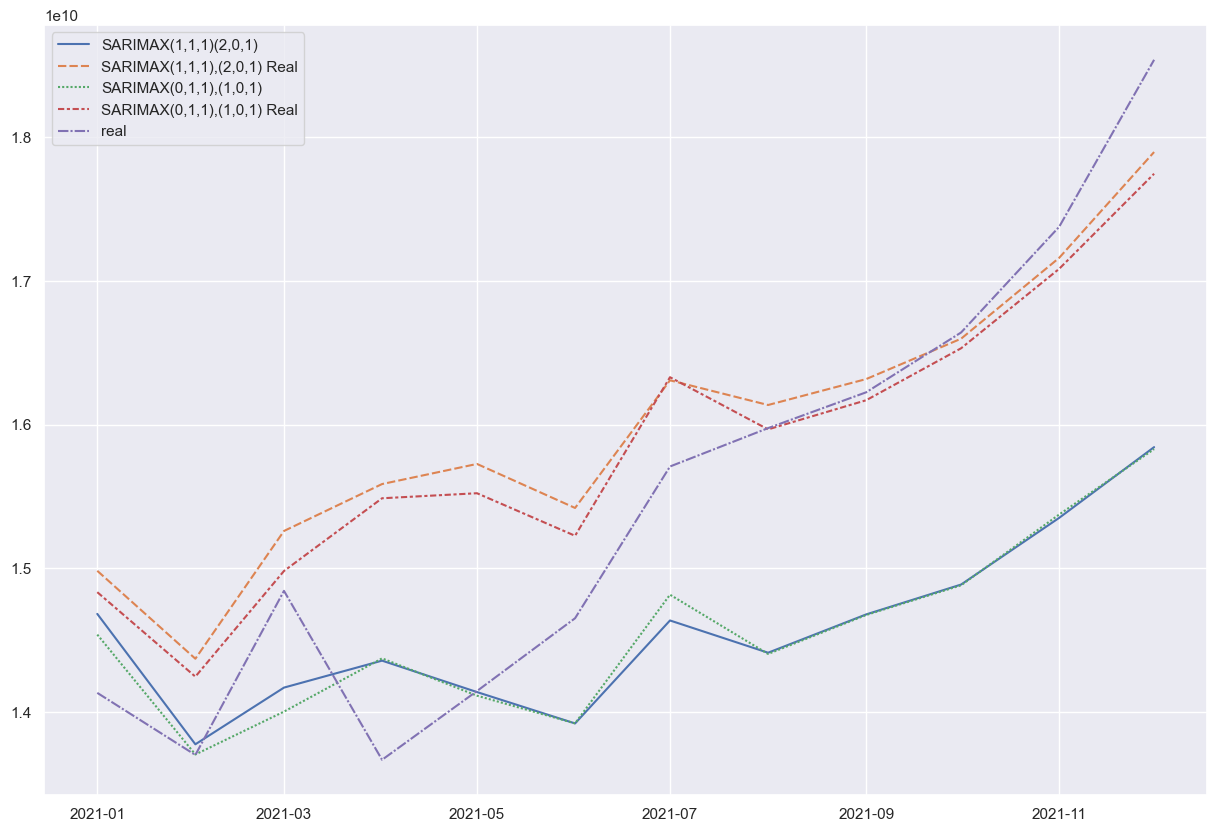

In [101]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

In [102]:
df_arima_rmse = pd.DataFrame(data=previsoes['rmse'][0:4], index= previsoes['nome'][0:4]).transpose()

In [103]:
df_arima_mape = pd.DataFrame(data=previsoes['mape'][0:4], index= previsoes['nome'][0:4]).transpose()

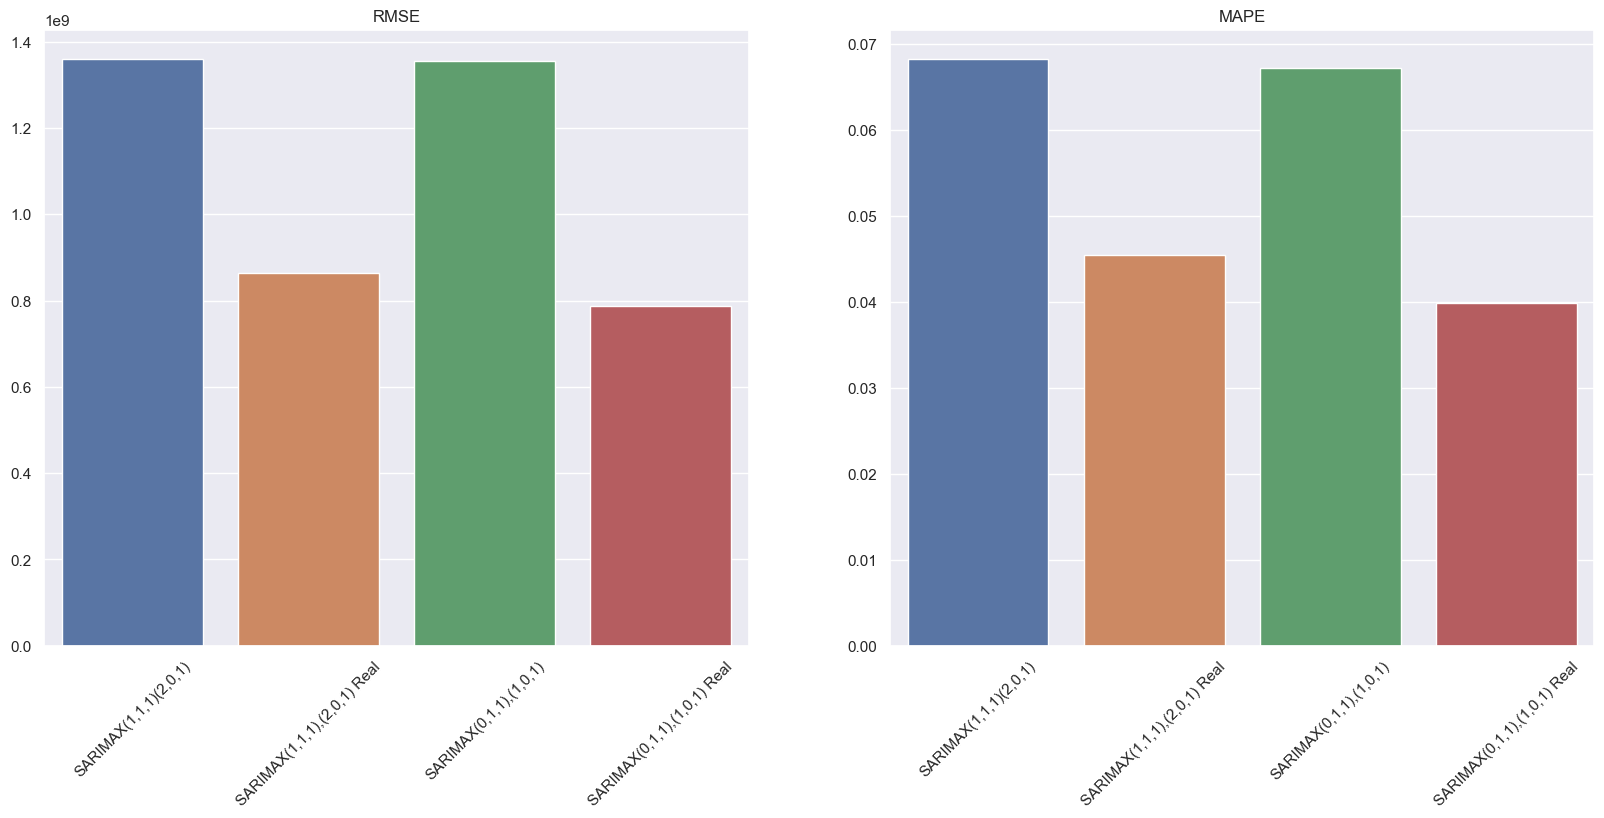

In [104]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_arima_rmse)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_arima_mape)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

## Modelo de Markov-Switching

A biblioteca statsmodel não tem implementado o método de forecast do modelo de Markov Switching. Por isso o forecast foi realizado no Ox e os dados estão sendo importados aqui.
Foram feitos 3 modelos usando as mesmas variáveis e 2 mudanças de regime:
- log icms em primeira diferença - Y
- constante - mudança de regime (*regime switching*)
- ibc-br real em primeira diferença - (*regime switching*) 
- igp-m real em segunda diferença - (*regime switching*) 
- dias úteis em nível - X (variável)
- 11 dummies sazonais centradas - X (variável)

E foram usados 3 tipos de variância
- variância fixa (*fixed variance*)
- mudança de variância (*switching variance*)
- componente média-variância (*mean-variance component*).

In [106]:
markov_forecast_df = pd.read_csv('forecast_markov.csv', delimiter=';', decimal=',')
markov_forecast_df = markov_forecast_df[-24:-12]

### Modelo com Variância Fixa

In [107]:
arq1 = open('./ox/21_results_multi_fixed_prev.txt', 'r')
print(arq1.read())
arq1.close()


Switching( 7) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2020-12-01

                Coefficient   Std.Error  t-value  t-prob
dias_uteis        0.0100917    0.003917     2.58   0.011
CSeasonal         -0.106690     0.01491    -7.16   0.000
CSeasonal_1      -0.0914502     0.01777    -5.14   0.000
CSeasonal_2      -0.0674103     0.02144    -3.14   0.002
CSeasonal_3      0.00188731     0.01246    0.151   0.880
CSeasonal_4      -0.0732612     0.01191    -6.15   0.000
CSeasonal_5      -0.0443117     0.01205    -3.68   0.000
CSeasonal_6      -0.0734131     0.01481    -4.96   0.000
CSeasonal_7      -0.0565975     0.01218    -4.65   0.000
CSeasonal_8      -0.0194978     0.01187    -1.64   0.102
CSeasonal_9      -0.0469272     0.01287    -3.65   0.000
CSeasonal_10     -0.0497691     0.01475    -3.37   0.001
Constant(0)       -0.204770  

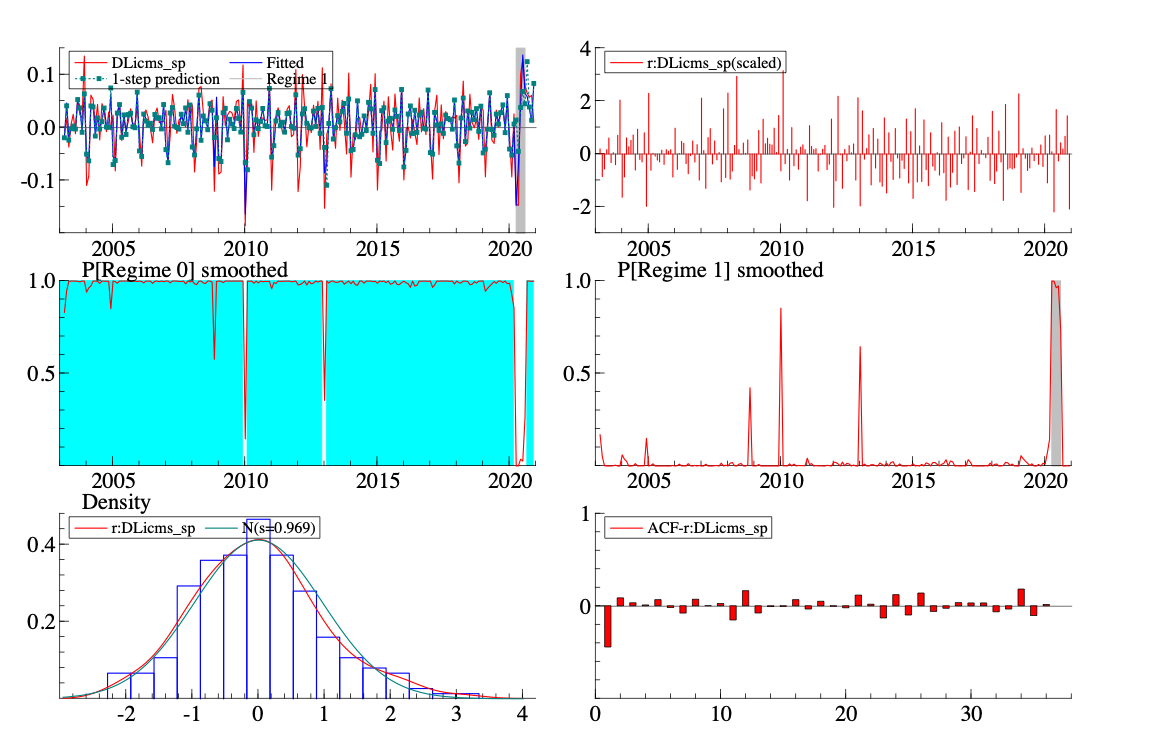

#### Previsões com Exógenas Previstas

In [108]:
y_markov_fixed_pred = np.exp(np.cumsum(markov_forecast_df['21_forecast_multi_fixed_prev'])+icms_train[-1])
y_markov_fixed_pred.index = icms_test.index
y_markov_fixed_pred

date
2021-01-01    1.388196e+10
2021-02-01    1.318726e+10
2021-03-01    1.358394e+10
2021-04-01    1.412072e+10
2021-05-01    1.388180e+10
2021-06-01    1.408142e+10
2021-07-01    1.426604e+10
2021-08-01    1.443494e+10
2021-09-01    1.489887e+10
2021-10-01    1.512680e+10
2021-11-01    1.503102e+10
2021-12-01    1.624713e+10
Name: 21_forecast_multi_fixed_prev, dtype: float64

In [109]:
previsoes['nome'].append('Markov-Fixed')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred)

In [110]:
RMSE_markov_fixed = mean_squared_error(icms_test, y_markov_fixed_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed)
RMSE_markov_fixed

1346691876.0962172

In [111]:
MAPE_markov_fixed = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred)
previsoes['mape'].append(MAPE_markov_fixed)
MAPE_markov_fixed

0.070868630443933

In [112]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred, icms_test)])

#### Previsões com Exógenas Reais

In [113]:
y_markov_fixed_pred_r = np.exp(np.cumsum(markov_forecast_df['21_forecast_multi_fixed'])+icms_train[-1])
y_markov_fixed_pred_r.index = icms_test.index
y_markov_fixed_pred_r

date
2021-01-01    1.395037e+10
2021-02-01    1.354714e+10
2021-03-01    1.431726e+10
2021-04-01    1.509695e+10
2021-05-01    1.513747e+10
2021-06-01    1.563482e+10
2021-07-01    1.580829e+10
2021-08-01    1.601838e+10
2021-09-01    1.648655e+10
2021-10-01    1.643637e+10
2021-11-01    1.648732e+10
2021-12-01    1.794126e+10
Name: 21_forecast_multi_fixed, dtype: float64

In [114]:
previsoes['nome'].append('Markov-Fixed Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred_r)

In [115]:
RMSE_markov_fixed_r = mean_squared_error(icms_test, y_markov_fixed_pred_r, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed_r)
RMSE_markov_fixed_r

682599355.7133687

In [116]:
MAPE_markov_fixed_r = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred_r)
previsoes['mape'].append(MAPE_markov_fixed_r)
MAPE_markov_fixed_r

0.03517609884179862

In [117]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred_r, icms_test)])

### Modelo com mudança da Variância

In [118]:
arq2 = open('./ox/21_results_multi_var_prev.txt', 'r')
print(arq2.read())
arq2.close()


Switching( 8) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2020-12-01

                Coefficient   Std.Error  t-value  t-prob
dias_uteis        0.0132243    0.002630     5.03   0.000
CSeasonal        -0.0587590     0.01340    -4.39   0.000
CSeasonal_1      -0.0975412     0.01204    -8.10   0.000
CSeasonal_2      -0.0432393     0.01349    -3.21   0.002
CSeasonal_3       0.0181196    0.009958     1.82   0.070
CSeasonal_4      -0.0626443     0.01034    -6.06   0.000
CSeasonal_5      -0.0372164     0.01021    -3.64   0.000
CSeasonal_6      -0.0592752     0.01063    -5.58   0.000
CSeasonal_7      -0.0498452     0.01027    -4.85   0.000
CSeasonal_8      -0.0116567    0.009974    -1.17   0.244
CSeasonal_9      -0.0339746    0.009775    -3.48   0.001
CSeasonal_10     -0.0300720     0.01113    -2.70   0.007
Constant(0)       -0.264898  

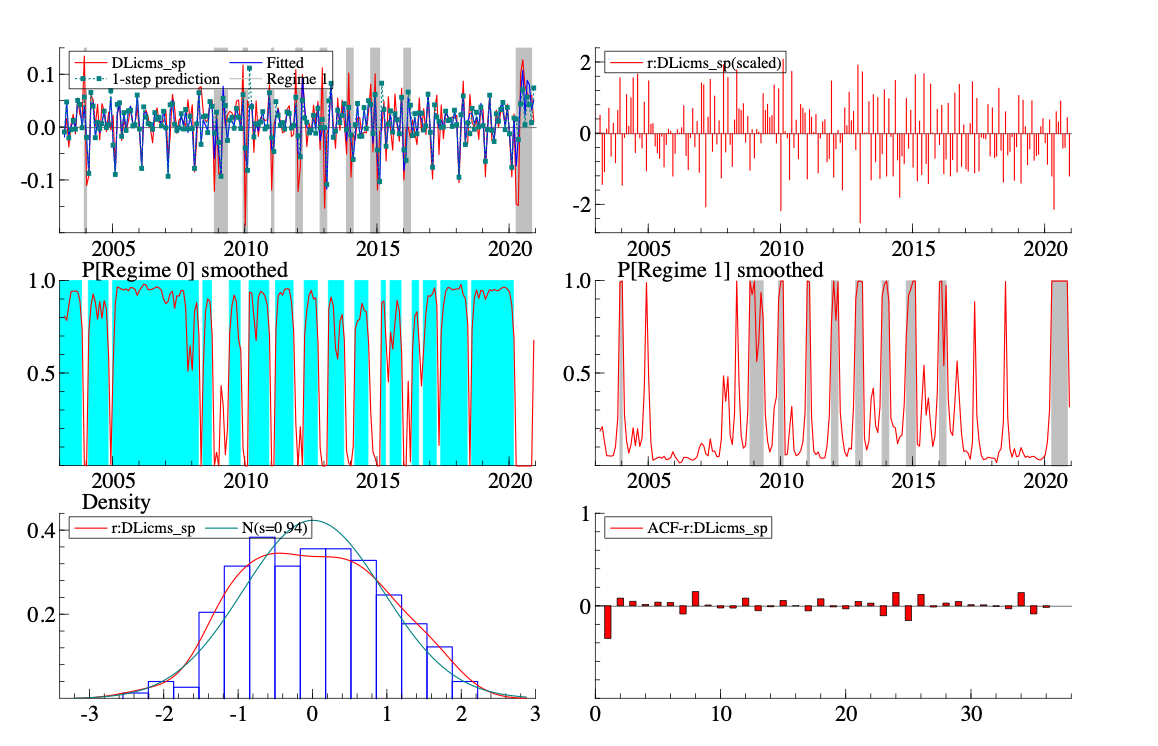

#### Previsões com Exógenas Previstas

In [119]:
y_markov_switching_pred = np.exp(np.cumsum(markov_forecast_df['21_forecast_multi_var_prev'])+icms_train[-1])
y_markov_switching_pred.index = icms_test.index
y_markov_switching_pred

date
2021-01-01    1.420515e+10
2021-02-01    1.312053e+10
2021-03-01    1.377072e+10
2021-04-01    1.431180e+10
2021-05-01    1.405872e+10
2021-06-01    1.420540e+10
2021-07-01    1.450955e+10
2021-08-01    1.466468e+10
2021-09-01    1.505765e+10
2021-10-01    1.525032e+10
2021-11-01    1.519309e+10
2021-12-01    1.630567e+10
Name: 21_forecast_multi_var_prev, dtype: float64

In [120]:
previsoes['nome'].append('Markov-Switching-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred)

In [121]:
RMSE_markov_switching = mean_squared_error(icms_test, y_markov_switching_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_switching)
RMSE_markov_switching

1235320212.8949466

In [122]:
MAPE_markov_switching = mean_absolute_percentage_error(icms_test, y_markov_switching_pred)
previsoes['mape'].append(MAPE_markov_switching)
MAPE_markov_switching

0.06361837035374655

In [123]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred, icms_test)])

#### Previsões com Exógenas Reais

In [124]:
y_markov_switching_pred_r = np.exp(np.cumsum(markov_forecast_df['21_forecast_multi_var'])+icms_train[-1])
y_markov_switching_pred_r.index = icms_test.index
y_markov_switching_pred_r

date
2021-01-01    1.410465e+10
2021-02-01    1.298062e+10
2021-03-01    1.354055e+10
2021-04-01    1.388442e+10
2021-05-01    1.338541e+10
2021-06-01    1.333682e+10
2021-07-01    1.348645e+10
2021-08-01    1.354047e+10
2021-09-01    1.393060e+10
2021-10-01    1.391987e+10
2021-11-01    1.402300e+10
2021-12-01    1.514027e+10
Name: 21_forecast_multi_var, dtype: float64

In [125]:
previsoes['nome'].append('Markov-Switching-Var Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred_r)

In [126]:
RMSE_markov_switching_r = mean_squared_error(icms_test, y_markov_switching_pred_r, squared=False)
previsoes['rmse'].append(RMSE_markov_switching_r)
RMSE_markov_switching_r

2059338838.3117604

In [127]:
MAPE_markov_switching_r = mean_absolute_percentage_error(icms_test, y_markov_switching_pred_r)
previsoes['mape'].append(MAPE_markov_switching_r)
MAPE_markov_switching_r

0.10640314631247133

In [128]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred_r, icms_test)])

### Componente Média-Variância

In [129]:
arq3 = open('./ox/21_results_multi_mean_var_prev.txt', 'r')
print(arq3.read())
arq3.close()


Switching( 9) Modelling DLicms_sp by MS_Component(2, 2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2020-12-01

                Coefficient   Std.Error  t-value  t-prob
dias_uteis        0.0142911    0.003082     4.64   0.000
CSeasonal        -0.0871113     0.04956    -1.76   0.080
CSeasonal_1      -0.0999936     0.01357    -7.37   0.000
CSeasonal_2      -0.0458153     0.01837    -2.49   0.013
CSeasonal_3       0.0135512     0.01041     1.30   0.195
CSeasonal_4      -0.0669399     0.01155    -5.80   0.000
CSeasonal_5      -0.0424558     0.01158    -3.67   0.000
CSeasonal_6      -0.0646823     0.01182    -5.47   0.000
CSeasonal_7      -0.0547230     0.01059    -5.17   0.000
CSeasonal_8      -0.0153642     0.01015    -1.51   0.132
CSeasonal_9      -0.0403652     0.01201    -3.36   0.001
CSeasonal_10     -0.0376545     0.01114    -3.38   0.001
Constant(0)     

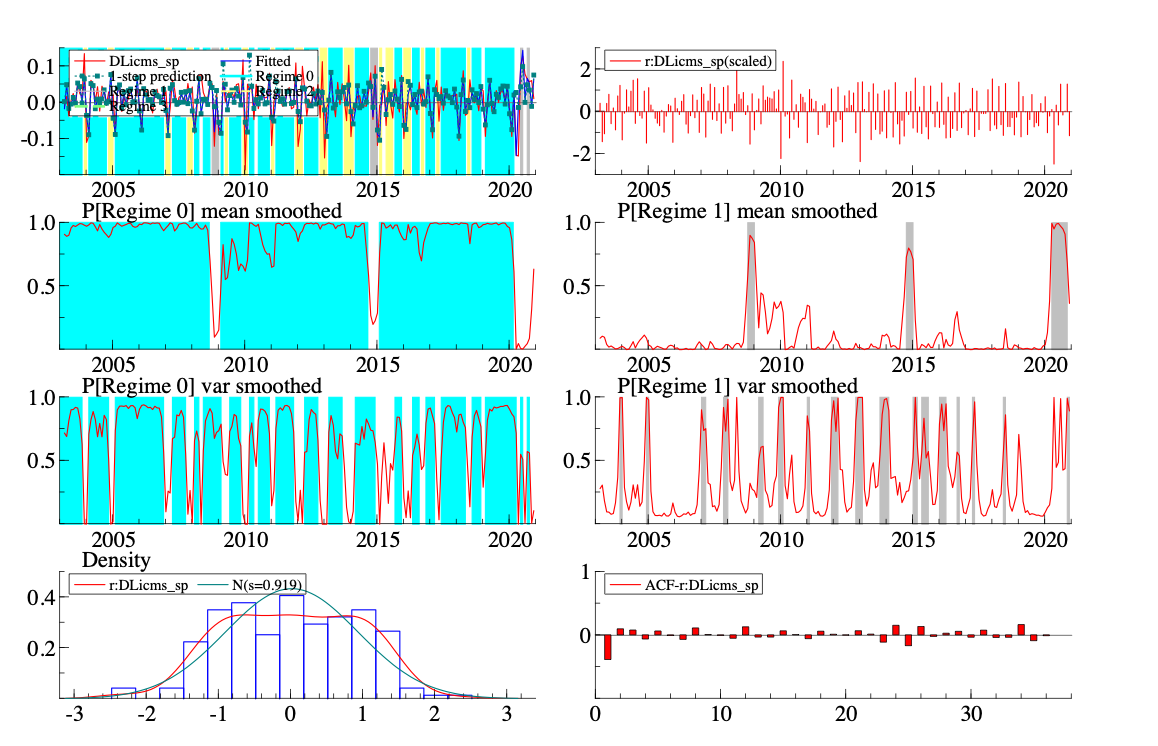

#### Previsões com Exógenas Previstas

In [130]:
y_markov_mean_var_pred = np.exp(np.cumsum(markov_forecast_df['21_forecast_multi_mean_var_prev'])+icms_train[-1])
y_markov_mean_var_pred.index = icms_test.index
y_markov_mean_var_pred

date
2021-01-01    1.377231e+10
2021-02-01    1.275169e+10
2021-03-01    1.349655e+10
2021-04-01    1.404367e+10
2021-05-01    1.383086e+10
2021-06-01    1.399301e+10
2021-07-01    1.427262e+10
2021-08-01    1.446279e+10
2021-09-01    1.491646e+10
2021-10-01    1.503496e+10
2021-11-01    1.496370e+10
2021-12-01    1.619899e+10
Name: 21_forecast_multi_mean_var_prev, dtype: float64

In [131]:
previsoes['nome'].append('Markov-Mean-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred)

In [132]:
RMSE_markov_mean_var = mean_squared_error(icms_test, y_markov_mean_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var)
RMSE_markov_mean_var

1397896481.5007024

In [133]:
MAPE_markov_mean_var = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred)
previsoes['mape'].append(MAPE_markov_mean_var)
MAPE_markov_mean_var

0.07571660218604674

In [134]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred, icms_test)])

#### Previsões com Exógenas Reais

In [135]:
y_markov_mean_var_pred_r = np.exp(np.cumsum(markov_forecast_df['21_forecast_multi_mean_var'])+icms_train[-1])
y_markov_mean_var_pred_r.index = icms_test.index
y_markov_mean_var_pred_r

date
2021-01-01    1.366713e+10
2021-02-01    1.262188e+10
2021-03-01    1.325718e+10
2021-04-01    1.357454e+10
2021-05-01    1.306696e+10
2021-06-01    1.298533e+10
2021-07-01    1.311585e+10
2021-08-01    1.319759e+10
2021-09-01    1.364785e+10
2021-10-01    1.363727e+10
2021-11-01    1.368872e+10
2021-12-01    1.487951e+10
Name: 21_forecast_multi_mean_var, dtype: float64

In [136]:
previsoes['nome'].append('Markov-Mean-Var Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred_r)

In [137]:
RMSE_markov_mean_var_r = mean_squared_error(icms_test, y_markov_mean_var_pred_r, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var_r)
RMSE_markov_mean_var_r

2326076589.0292263

In [138]:
MAPE_markov_mean_var_r = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred_r)
previsoes['mape'].append(MAPE_markov_mean_var_r)
MAPE_markov_mean_var_r

0.12527595484774692

In [139]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred_r, icms_test)])

### Comparação dos Modelos de Markov com Endógenas Previstas e Reais

In [140]:
previsoes['nome']

['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(1,1,1),(2,0,1) Real',
 'SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Fixed',
 'Markov-Fixed Real',
 'Markov-Switching-Var',
 'Markov-Switching-Var Real',
 'Markov-Mean-Var',
 'Markov-Mean-Var Real']

In [141]:
prev_markov_df = pd.DataFrame(data={previsoes['nome'][4]: previsoes['previsoes'][4],
                                    previsoes['nome'][5]: previsoes['previsoes'][5],
                                    previsoes['nome'][6]: previsoes['previsoes'][6],
                                    previsoes['nome'][7]: previsoes['previsoes'][7],
                                    previsoes['nome'][8]: previsoes['previsoes'][8],
                                    previsoes['nome'][9]: previsoes['previsoes'][9]
                                   })
prev_markov_df['real'] = icms_test
prev_markov_df

Markov-Fixed  Markov-Fixed Real  Markov-Switching-Var  \
date                                                                
2021-01-01  1.388196e+10       1.395037e+10          1.420515e+10   
2021-02-01  1.318726e+10       1.354714e+10          1.312053e+10   
2021-03-01  1.358394e+10       1.431726e+10          1.377072e+10   
2021-04-01  1.412072e+10       1.509695e+10          1.431180e+10   
2021-05-01  1.388180e+10       1.513747e+10          1.405872e+10   
2021-06-01  1.408142e+10       1.563482e+10          1.420540e+10   
2021-07-01  1.426604e+10       1.580829e+10          1.450955e+10   
2021-08-01  1.443494e+10       1.601838e+10          1.466468e+10   
2021-09-01  1.489887e+10       1.648655e+10          1.505765e+10   
2021-10-01  1.512680e+10       1.643637e+10          1.525032e+10   
2021-11-01  1.503102e+10       1.648732e+10          1.519309e+10   
2021-12-01  1.624713e+10       1.794126e+10          1.630567e+10   

            Markov-Switching-Var Real  Markov-Mean-Var  Markov-Mean-Var Real  \
date                                                                           
2021-01-01               1.410465e+10     1.377231e+10          1.366713e+10   
2021-02-01               1.298062e+10     1.275169e+10          1.262188e+10   
2021-03-01               1.354055e+10     1.349655e+10          1.325718e+10   
2021-04-01               1.388442e+10     1.404367e+10          1.357454e+10   
2021-05-01               1.338541e+10     1.383086e+10          1.306696e+10   
2021-06-01               1.333682e+10     1.399301e+10          1.298533e+10   
2021-07-01               1.348645e+10     1.427262e+10          1.311585e+10   
2021-08-01               1.354047e+10     1.446279e+10          1.319759e+10   
2021-09-01               1.393060e+10     1.491646e+10          1.364785e+10   
2021-10-01               1.391987e+10     1.503496e+10          1.363727e+10   
2021-11-01               1.402300e+10     1.496370e+10          1.368872e+10   
2021-12-01               1.514027e+10     1.619899e+10          1.487951e+10   

                    real  
date                      
2021-01-01  1.413347e+10  
2021-02-01  1.370153e+10  
2021-03-01  1.484308e+10  
2021-04-01  1.366780e+10  
2021-05-01  1.414623e+10  
2021-06-01  1.465265e+10  
2021-07-01  1.570838e+10  
2021-08-01  1.597532e+10  
2021-09-01  1.622460e+10  
2021-10-01  1.664068e+10  
2021-11-01  1.737603e+10  
2021-12-01  1.853772e+10

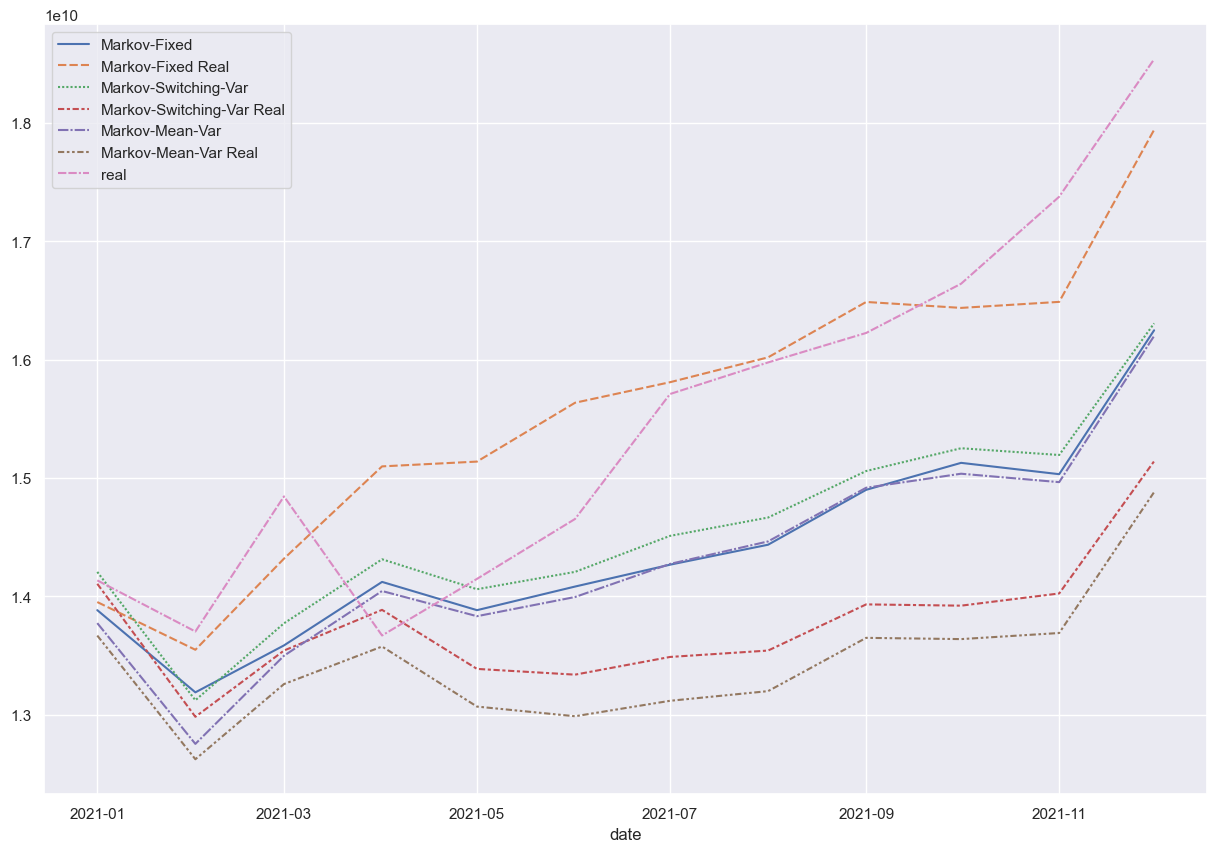

In [142]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_markov_df)

In [143]:
df_markov_rmse = pd.DataFrame(data=previsoes['rmse'][4:10], index= previsoes['nome'][4:10]).transpose()

In [144]:
df_markov_mape = pd.DataFrame(data=previsoes['mape'][4:10], index= previsoes['nome'][4:10]).transpose()

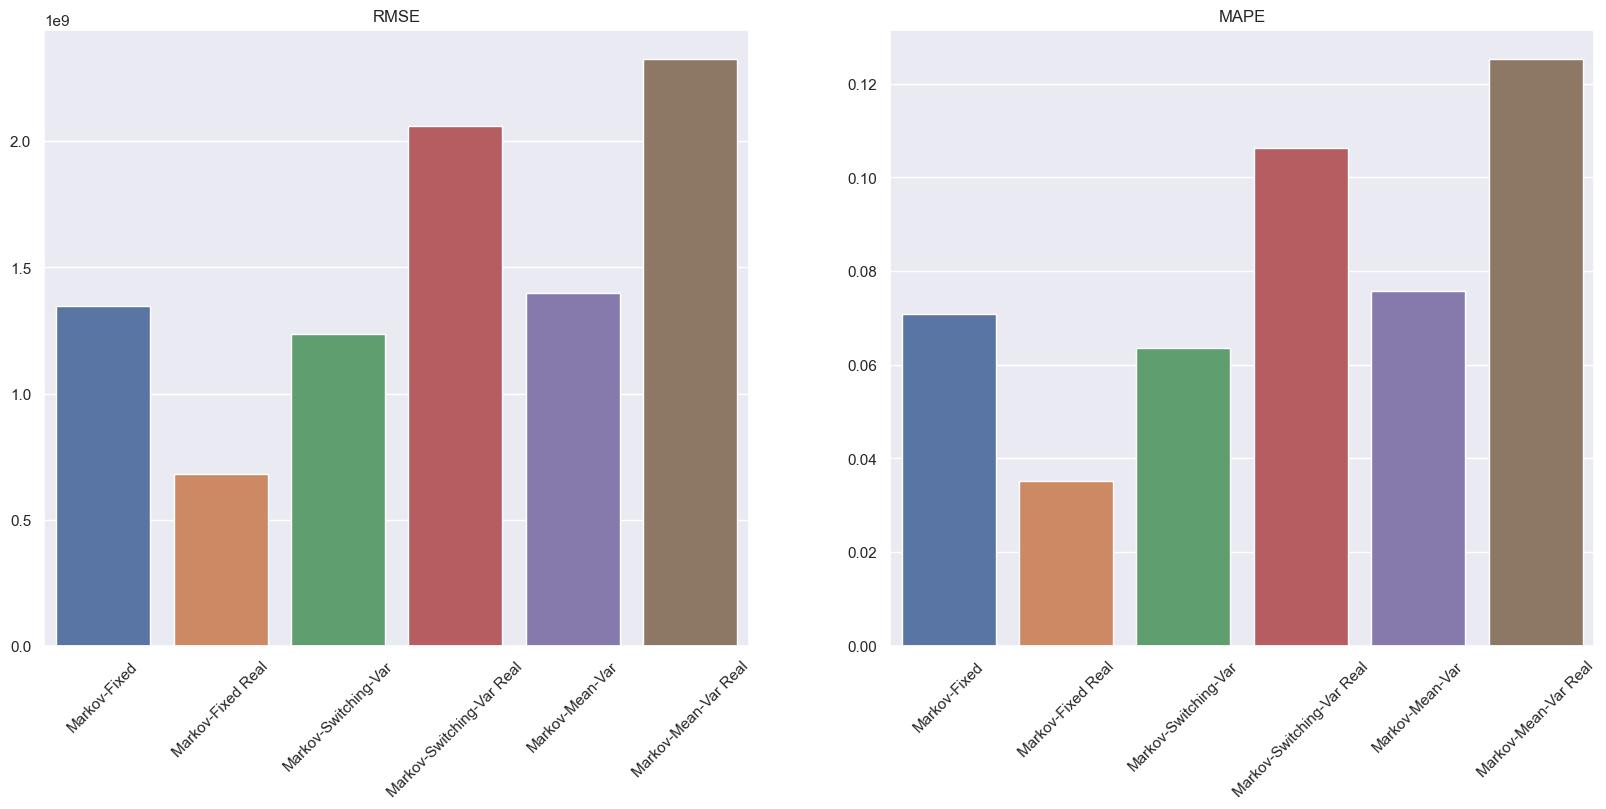

In [145]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_markov_rmse)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_markov_mape)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série com as Variáveis Exógenas Previstas.
As redes neurais precisam de conjuntos de características e de etiquetas separados. As variáveis exógenas serão o conjunto de características e a variável endógena será o conjunto de etiquetas.

In [146]:
X_data = np.append(exog[:,:4], np.roll(exog[:,:4], 1, axis = 0), axis = 1)
X_data = np.append(X_data, np.roll(exog[:,:4], 2, axis = 0), axis = 1)[2:]
Y_data = icms_ts[2:].to_numpy()

In [147]:
X_data.shape, Y_data.shape

((226, 12), (226,))

### Montagem da Série com as Variáveis Exógenas Reais

In [148]:
X_reais_data = np.append(exog_reais[:,:4], np.roll(exog_reais[:,:4], 1, axis = 0), axis = 1)
X_reais_data = np.append(X_reais_data, np.roll(exog_reais[:,:4], 2, axis = 0), axis = 1)[2:]

In [149]:
X_reais_data.shape

(226, 12)

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [150]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
Y_train = Y_data[:-24]
Y_val = Y_data[-24:-12]
Y_test = np.exp(Y_data[-12:]) # tirando o log
print(Y_train.shape, Y_val.shape, Y_test.shape)

(202, 12) (12, 12) (12, 12)
(202,) (12,) (12,)


In [151]:
X_reais_test = X_reais_data[-12:]
print(X_reais_test.shape)

(12, 12)


In [152]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(X_train.shape[1]))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)
X_reais_test_std = enc_x.transform(X_reais_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)
print(X_reais_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(202, 12)
(12, 12)
(12, 12)
(12, 12)


In [153]:
x_train = X_train_std.reshape(X_train_std.shape[0], X_train_std.shape[1], 1)
x_val = X_val_std.reshape(X_val_std.shape[0], X_val_std.shape[1], 1)
x_test = X_test_std.reshape(X_test_std.shape[0], X_test_std.shape[1], 1)
x_reais_test = X_reais_test_std.reshape(X_reais_test_std.shape[0], X_reais_test_std.shape[1], 1)
print(x_train.shape, x_val.shape, x_test.shape, x_reais_test.shape)

y_train = Y_train.reshape(Y_train.shape[0], 1)
y_val = Y_val.reshape(Y_val.shape[0], 1)
y_test = Y_test.reshape(Y_test.shape[0], 1)
print(y_train.shape, y_val.shape, y_test.shape)

(202, 12, 1) (12, 12, 1) (12, 12, 1) (12, 12, 1)
(202, 1) (12, 1) (12, 1)


### Criando o modelo LSTM

In [154]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [155]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [156]:
# Épocas
EPOCHS = 1000
NEURONIOS = 600
DROPOUT = 0.15
LR = 1e-5
BATCH = 8

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (12, 1), return_sequences = False,
        units = NEURONIOS))

# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=LR))

In [157]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 600)               1444800   
                                                                 
 dense (Dense)               (None, 1)                 601       
                                                                 
Total params: 1445401 (5.51 MB)
Trainable params: 1445401 (5.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [158]:
# History object for plotting our model loss by epoch
history = model.fit(x_train, y_train, batch_size = BATCH, 
                    epochs = EPOCHS, validation_data = (x_val, y_val),
                    callbacks = [rlrop, early_stop])

Epoch 1/1000
26/26 [==============================] - 3s 48ms/step - loss: 99.9469 - val_loss: 99.6552 - lr: 1.0000e-05
Epoch 2/1000
26/26 [==============================] - 1s 31ms/step - loss: 99.6794 - val_loss: 99.1665 - lr: 1.0000e-05
Epoch 3/1000
26/26 [==============================] - 1s 34ms/step - loss: 99.3757 - val_loss: 98.5819 - lr: 1.0000e-05
Epoch 4/1000
26/26 [==============================] - 1s 37ms/step - loss: 98.9992 - val_loss: 97.8076 - lr: 1.0000e-05
Epoch 5/1000
26/26 [==============================] - 1s 32ms/step - loss: 98.4983 - val_loss: 96.6527 - lr: 1.0000e-05
Epoch 6/1000
26/26 [==============================] - 1s 35ms/step - loss: 97.7154 - val_loss: 94.7523 - lr: 1.0000e-05
Epoch 7/1000
26/26 [==============================] - 1s 33ms/step - loss: 96.1951 - val_loss: 90.9401 - lr: 1.0000e-05
Epoch 8/1000
26/26 [==============================] - 1s 31ms/step - loss: 93.2196 - val_loss: 81.4375 - lr: 1.0000e-05
Epoch 9/1000
26/26 [====================

Epoch 70/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.9491 - val_loss: 0.8643 - lr: 1.0000e-07
Epoch 71/1000
26/26 [==============================] - 1s 35ms/step - loss: 1.0093 - val_loss: 0.8633 - lr: 1.0000e-07
Epoch 72/1000
26/26 [==============================] - 1s 35ms/step - loss: 0.9609 - val_loss: 0.8636 - lr: 1.0000e-07
Epoch 73/1000
26/26 [==============================] - 1s 37ms/step - loss: 1.0599 - val_loss: 0.8598 - lr: 1.0000e-07
Epoch 74/1000
26/26 [==============================] - 1s 36ms/step - loss: 0.8564 - val_loss: 0.8627 - lr: 1.0000e-07
Epoch 75/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.8573 - val_loss: 0.8690 - lr: 1.0000e-07
Epoch 76/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.9005 - val_loss: 0.8765 - lr: 1.0000e-07
Epoch 77/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.9766 - val_loss: 0.8781 - lr: 1.0000e-07
Epoch 78/1000
26/26 [===========================

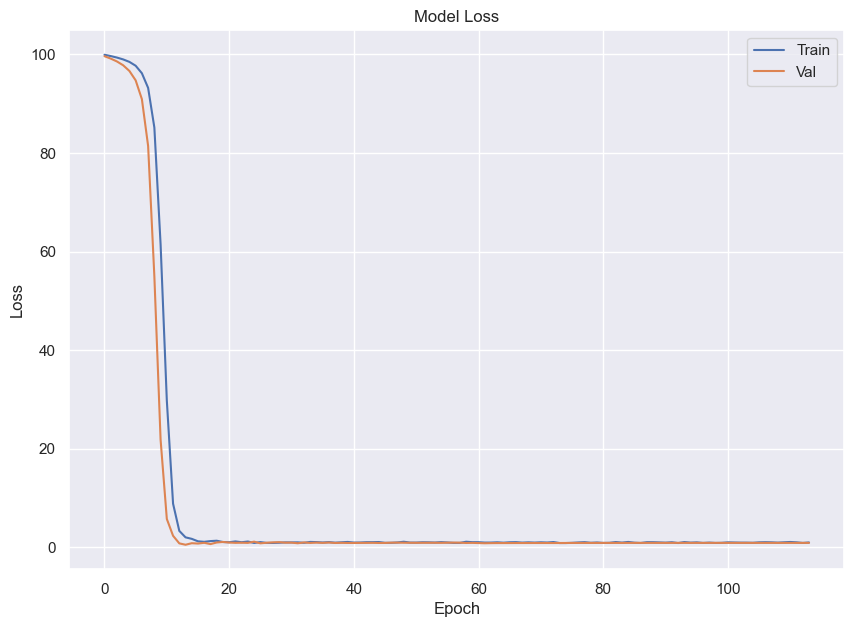

In [159]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão 12 meses em Teste com Exógenas Previstas

In [160]:
Y_pred1 = np.exp(model.predict(x_test))

1/1 [==============================] - 0s 434ms/step


In [161]:
y_pred1 = pd.Series(Y_pred1.ravel())
y_pred1.index = icms_ts.index[-12:]
y_pred1

date
2021-01-01    11772268544
2021-02-01    11709520896
2021-03-01    12127026176
2021-04-01    11844860928
2021-05-01    11879682048
2021-06-01    11904427008
2021-07-01    12098239488
2021-08-01    12101885952
2021-09-01    11981102080
2021-10-01    12044385280
2021-11-01    12042661888
2021-12-01    12158777344
Name: RNN-LSTM, dtype: int64

In [162]:
RMSE_lstm1 = mean_squared_error(y_test, y_pred1, squared=False)
RMSE_lstm1

3755429871.483564

In [163]:
MAPE_lstm1 = mean_absolute_percentage_error(y_test, y_pred1)
MAPE_lstm1

0.2198064559746842

In [164]:
previsoes['nome'].append('RNN-LSTM')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(y_pred1)

previsoes['rmse'].append(RMSE_lstm1)

previsoes['mape'].append(MAPE_lstm1)

In [165]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred1, y_test)])

### Previsão 12 meses em Teste com Exógenas Reais

In [166]:
Y_pred2 = np.exp(model.predict(x_reais_test))

1/1 [==============================] - 0s 25ms/step


In [167]:
y_pred2 = pd.Series(Y_pred2.ravel())
y_pred2.index = icms_ts.index[-12:]
y_pred2

date
2021-01-01    11832825000
2021-02-01    11892876000
2021-03-01    12339915000
2021-04-01    12104886000
2021-05-01    12111076000
2021-06-01    12105026000
2021-07-01    12246687000
2021-08-01    12246314000
2021-09-01    12138273000
2021-10-01    12137855000
2021-11-01    12187639000
2021-12-01    12321522000
Name: RNN-LSTM-Real, dtype: int64

In [168]:
RMSE_lstm2 = mean_squared_error(y_test, y_pred2, squared=False)
RMSE_lstm2

3609338642.5467844

In [169]:
MAPE_lstm2 = mean_absolute_percentage_error(y_test, y_pred2)
MAPE_lstm2

0.20880652144332365

In [170]:
previsoes['nome'].append('RNN-LSTM-Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_pred2)

previsoes['rmse'].append(RMSE_lstm2)

previsoes['mape'].append(MAPE_lstm2)

In [171]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred2, y_test)])

## Resultados

In [172]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_test
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [173]:
df_prev

SARIMAX(1,1,1)(2,0,1)  SARIMAX(1,1,1),(2,0,1) Real  \
2021-01-01           1.468288e+10                 1.498258e+10   
2021-02-01           1.377577e+10                 1.437103e+10   
2021-03-01           1.417012e+10                 1.525976e+10   
2021-04-01           1.435768e+10                 1.558621e+10   
2021-05-01           1.413912e+10                 1.572612e+10   
2021-06-01           1.392085e+10                 1.541996e+10   
2021-07-01           1.463716e+10                 1.630797e+10   
2021-08-01           1.441280e+10                 1.613617e+10   
2021-09-01           1.467932e+10                 1.631654e+10   
2021-10-01           1.488712e+10                 1.659740e+10   
2021-11-01           1.535108e+10                 1.715999e+10   
2021-12-01           1.584315e+10                 1.789604e+10   

            SARIMAX(0,1,1),(1,0,1)  SARIMAX(0,1,1),(1,0,1) Real  Markov-Fixed  \
2021-01-01            1.453891e+10                 1.483396e+10  1.388196e+10   
2021-02-01            1.370487e+10                 1.424635e+10  1.318726e+10   
2021-03-01            1.400290e+10                 1.498131e+10  1.358394e+10   
2021-04-01            1.437355e+10                 1.548733e+10  1.412072e+10   
2021-05-01            1.411393e+10                 1.552235e+10  1.388180e+10   
2021-06-01            1.392125e+10                 1.522636e+10  1.408142e+10   
2021-07-01            1.481646e+10                 1.632952e+10  1.426604e+10   
2021-08-01            1.440419e+10                 1.596656e+10  1.443494e+10   
2021-09-01            1.467515e+10                 1.616935e+10  1.489887e+10   
2021-10-01            1.488197e+10                 1.653084e+10  1.512680e+10   
2021-11-01            1.537438e+10                 1.708361e+10  1.503102e+10   
2021-12-01            1.582923e+10                 1.774502e+10  1.624713e+10   

            Markov-Fixed Real  Markov-Switching-Var  \
2021-01-01       1.395037e+10          1.420515e+10   
2021-02-01       1.354714e+10          1.312053e+10   
2021-03-01       1.431726e+10          1.377072e+10   
2021-04-01       1.509695e+10          1.431180e+10   
2021-05-01       1.513747e+10          1.405872e+10   
2021-06-01       1.563482e+10          1.420540e+10   
2021-07-01       1.580829e+10          1.450955e+10   
2021-08-01       1.601838e+10          1.466468e+10   
2021-09-01       1.648655e+10          1.505765e+10   
2021-10-01       1.643637e+10          1.525032e+10   
2021-11-01       1.648732e+10          1.519309e+10   
2021-12-01       1.794126e+10          1.630567e+10   

            Markov-Switching-Var Real  Markov-Mean-Var  Markov-Mean-Var Real  \
2021-01-01               1.410465e+10     1.377231e+10          1.366713e+10   
2021-02-01               1.298062e+10     1.275169e+10          1.262188e+10   
2021-03-01               1.354055e+10     1.349655e+10          1.325718e+10   
2021-04-01               1.388442e+10     1.404367e+10          1.357454e+10   
2021-05-01               1.338541e+10     1.383086e+10          1.306696e+10   
2021-06-01               1.333682e+10     1.399301e+10          1.298533e+10   
2021-07-01               1.348645e+10     1.427262e+10          1.311585e+10   
2021-08-01               1.354047e+10     1.446279e+10          1.319759e+10   
2021-09-01               1.393060e+10     1.491646e+10          1.364785e+10   
2021-10-01               1.391987e+10     1.503496e+10          1.363727e+10   
2021-11-01               1.402300e+10     1.496370e+10          1.368872e+10   
2021-12-01               1.514027e+10     1.619899e+10          1.487951e+10   

                RNN-LSTM  RNN-LSTM-Real          real  
2021-01-01  1.177227e+10   1.183282e+10  1.413347e+10  
2021-02-01  1.170952e+10   1.189288e+10  1.370153e+10  
2021-03-01  1.212703e+10   1.233992e+10  1.484308e+10  
2021-04-01  1.184486e+10   1.210489e+10  1.366780e+10  
2021-05-01  1.187968e+10   1.211108e+10  1.414623e+10  
2021-0

In [174]:
df_erro

SARIMAX(1,1,1)(2,0,1) SARIMAX(1,1,1),(2,0,1) Real SARIMAX(0,1,1),(1,0,1)  \
0               3.887253                    6.007738               2.868611   
1                0.54181                    4.886282                0.02439   
2               4.533874                    2.807214               5.660422   
3               5.047479                   14.035973               5.163539   
4               0.050215                   11.168322               0.228281   
5               4.994335                    5.236618               4.991638   
6               6.819406                     3.81703               5.677955   
7                9.78086                    1.006819                9.83472   
8               9.524304                    0.566679               9.550038   
9              10.537795                    0.260098              10.568733   
10             11.653717                    1.243358               11.51961   
11             14.535589                    3.461492              14.610691   

   SARIMAX(0,1,1),(1,0,1) Real Markov-Fixed Markov-Fixed Real  \
0                     4.956244     1.779564          1.295549   
1                     3.976322     3.753366          1.126783   
2                     0.931221     8.483029          3.542583   
3                    13.312473     3.313741         10.456276   
4                     9.727861     1.869266          7.007148   
5                     3.915379     3.898498          6.703004   
6                     3.954194     9.181951          0.636054   
7                     0.054877      9.64229          0.269533   
8                     0.340576     8.171161           1.61449   
9                     0.660082     9.097451          1.227764   
10                    1.682881    13.495675          5.114601   
11                    4.276159    12.356364          3.217534   

   Markov-Switching-Var Markov-Switching-Var Real Markov-Mean-Var  \
0              0.507121                  0.203941        2.555364   
1              4.240404                  5.261541        6.932354   
2              7.224696                  8.775332        9.071819   
3              4.711777                  1.584902         2.74998   
4              0.618577                  5.378229        2.229306   
5              3.052397                   8.98015        4.501878   
6               7.63177                 14.144842        9.140084   
7              8.204155                 15.241351        9.467927   
8              7.192465                 14.139035        8.062686   
9              8.355168                 16.350327        9.649365   
10            12.562945                 19.296908       13.883073   
11             12.04057                 18.327218       12.616086   

   Markov-Mean-Var Real              RNN-LSTM         RNN-LSTM-Real  
0              3.299549   [16.70647594004498]  [16.278014713054677]  
1              7.879764  [14.538589998132856]  [13.200381043381187]  
2             10.684478  [18.298475481631645]  [16.864212767814394]  
3              0.682347  [13.337493050269988]  [11.435028787812076]  
4              7.629335  [16.022251244888757]   [14.38652201526853]  
5             11.379014   [18.75582583043289]  [17.386797364523918]  
6             16.504133  [22.982253781165426]  [22.037232580570606]  
7             17.387625  [24.246374538839124]  [23.342304851050468]  
8             15.881739  [26.154731110519357]  [25.186011474253057]  
9             18.048607  [27.620831814840713]   [27.05913767879098]  
10            21.220683  [30.693833077327152]  [29.859481999659575]  
11            19.733872  [34.410611301528164]  [33.532700455808914]

### Resultados Apenas das Redes Neurais

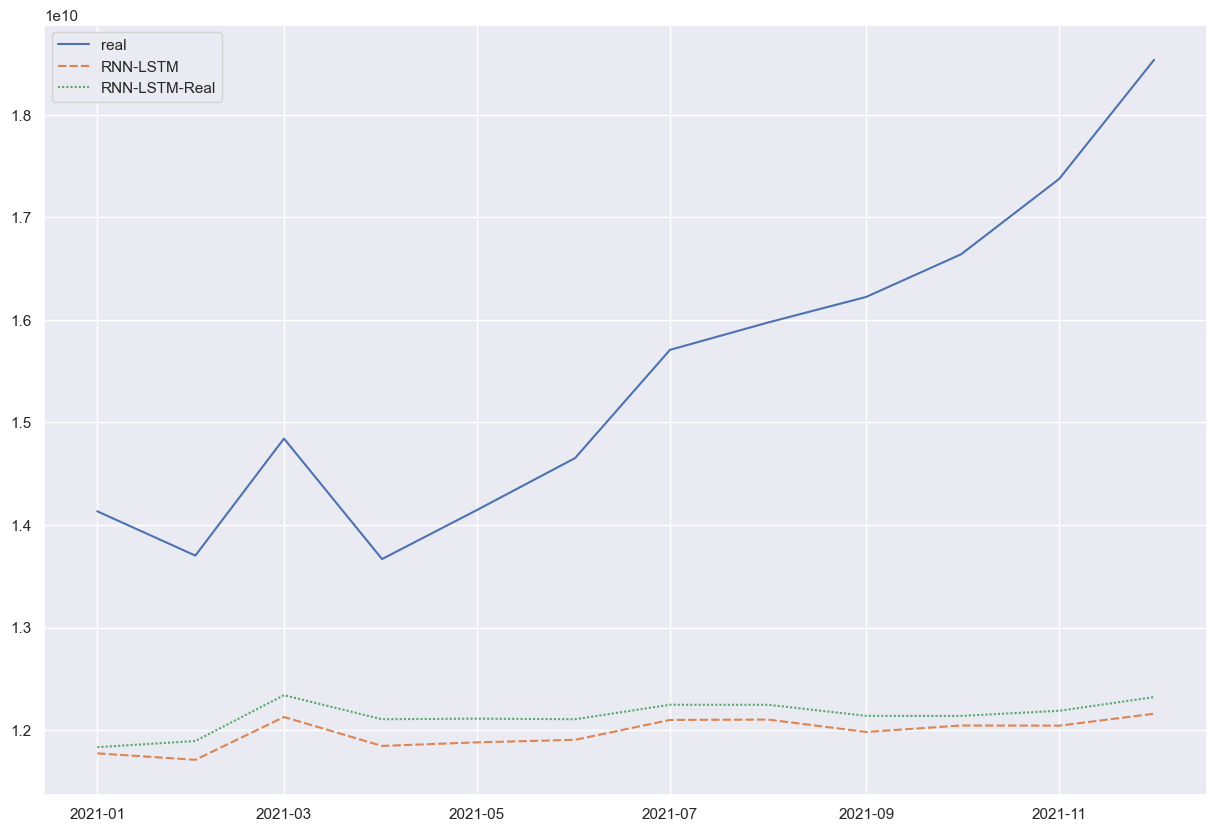

In [175]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev[['real', 'RNN-LSTM', 'RNN-LSTM-Real']])

In [176]:
df_rmse_lstm = df_rmse[['RNN-LSTM', 'RNN-LSTM-Real']]
df_mape_lstm = df_mape[['RNN-LSTM', 'RNN-LSTM-Real']]

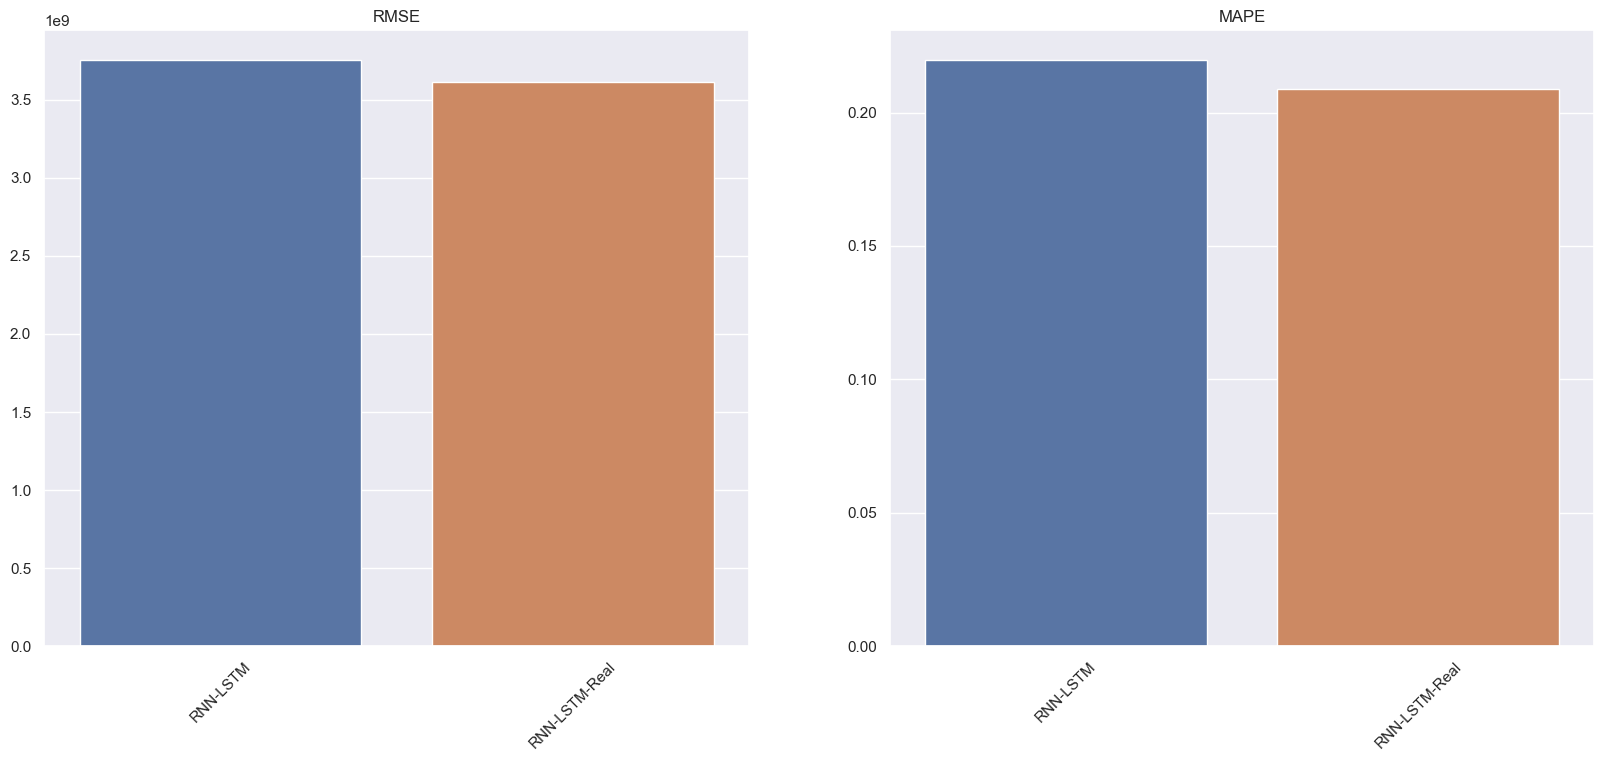

In [177]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_rmse_lstm)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_mape_lstm)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

### Resultados Gerais com os Dados Previstos

#### Previsões com os Dados Previstos

In [178]:
df_prev_prev = df_prev[['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM', 'real']]

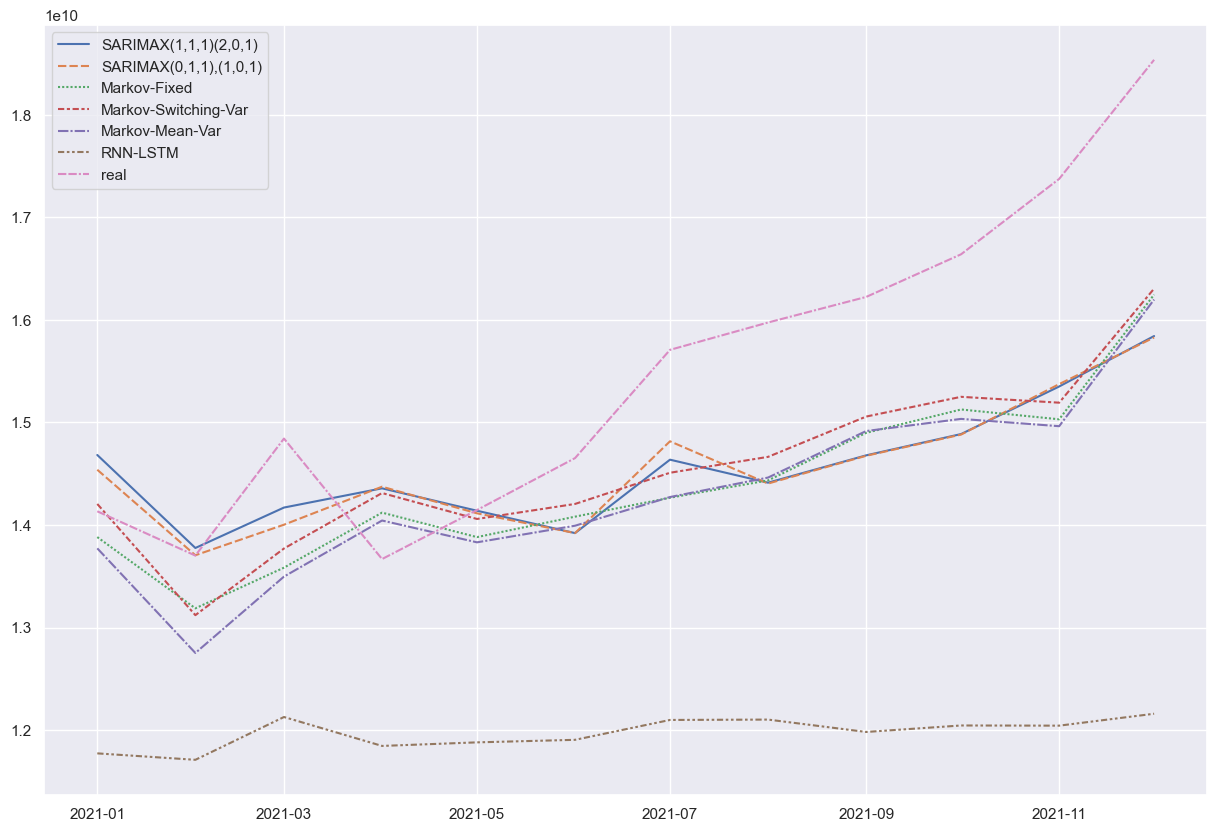

In [179]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev_prev)

#### RMSE com Dados Previstos

In [180]:
previsoes['nome']

['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(1,1,1),(2,0,1) Real',
 'SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Fixed',
 'Markov-Fixed Real',
 'Markov-Switching-Var',
 'Markov-Switching-Var Real',
 'Markov-Mean-Var',
 'Markov-Mean-Var Real',
 'RNN-LSTM',
 'RNN-LSTM-Real']

In [181]:
df_rmse

SARIMAX(1,1,1)(2,0,1)  SARIMAX(1,1,1),(2,0,1) Real  SARIMAX(0,1,1),(1,0,1)  \
0           1.359680e+09                 8.641990e+08            1.354151e+09   

   SARIMAX(0,1,1),(1,0,1) Real  Markov-Fixed  Markov-Fixed Real  \
0                 7.881960e+08  1.346692e+09       6.825994e+08   

   Markov-Switching-Var  Markov-Switching-Var Real  Markov-Mean-Var  \
0          1.235320e+09               2.059339e+09     1.397896e+09   

   Markov-Mean-Var Real      RNN-LSTM  RNN-LSTM-Real  
0          2.326077e+09  3.755430e+09   3.609339e+09

In [182]:
df_rmse_prev = df_rmse[['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM']]

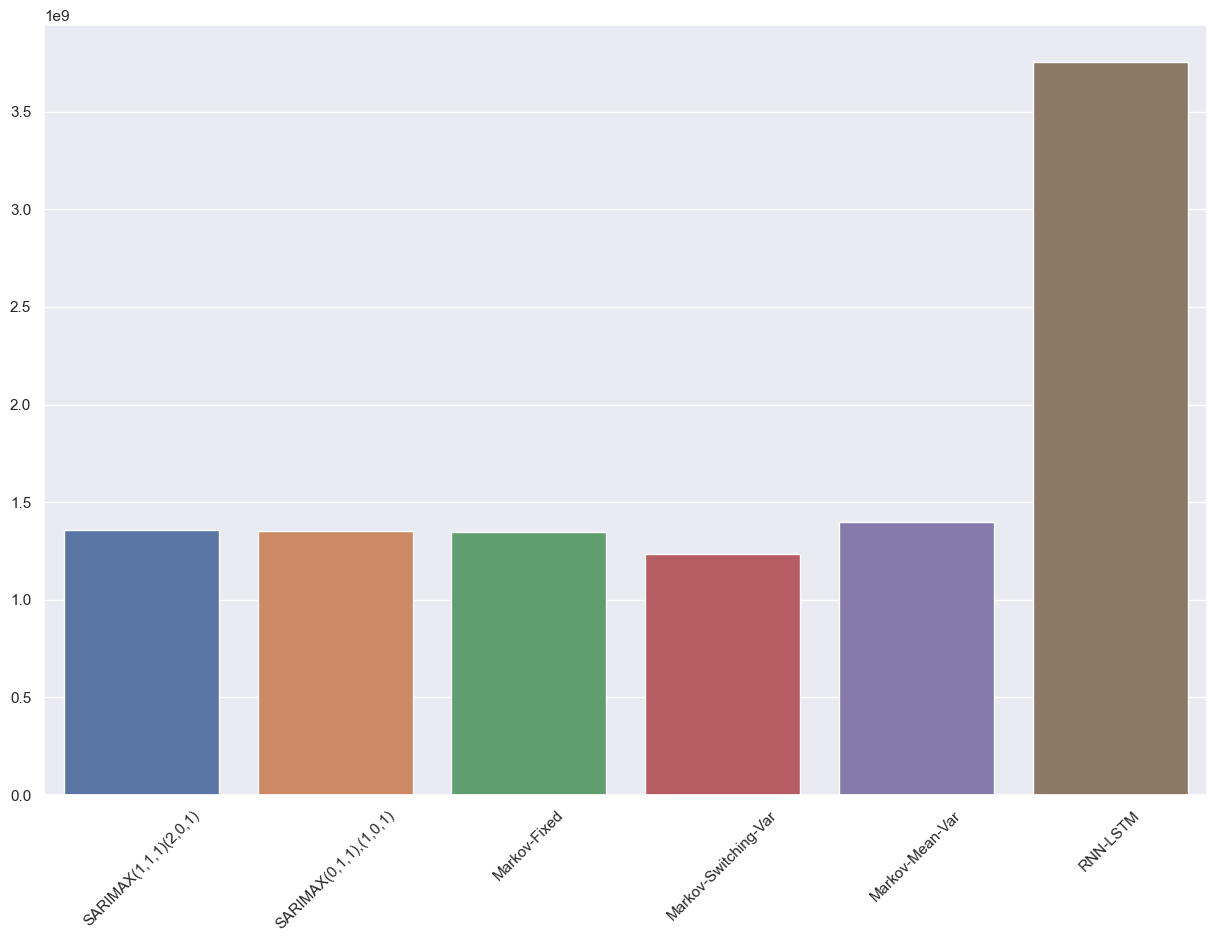

In [183]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_rmse_prev)
_ = plt.xticks(rotation=45)

#### MAPE dos Dados Previstos

In [184]:
df_mape_prev = df_mape[['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM']]

In [185]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_mape_prev)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [186]:
df_rmse_prev.index = ['RMSE']
df_mape_prev.index = ['MAPE']

In [187]:
df_metricas = df_rmse_prev.copy()
df_metricas = df_metricas.append(df_mape_prev)
df_metricas

SARIMAX(1,1,1)(2,0,1)  SARIMAX(0,1,1),(1,0,1)  Markov-Fixed  \
RMSE           1.359680e+09            1.354151e+09  1.346692e+09   
MAPE           6.825553e-02            6.724886e-02  7.086863e-02   

      Markov-Switching-Var  Markov-Mean-Var      RNN-LSTM  
RMSE          1.235320e+09     1.397896e+09  3.755430e+09  
MAPE          6.361837e-02     7.571660e-02  2.198065e-01

In [188]:
df_metricas.transpose().to_excel('./metricas_multi_2021.xlsx', index_label='modelo')

In [189]:
df_prev_prev.to_excel('./previsoes_multi_2021.xlsx', index_label='mes_ano')

In [190]:
print(df_metricas.transpose().to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
SARIMAX(1,1,1)(2,0,1)  &  1.359680e+09 &  0.068256 \\
SARIMAX(0,1,1),(1,0,1) &  1.354151e+09 &  0.067249 \\
Markov-Fixed           &  1.346692e+09 &  0.070869 \\
Markov-Switching-Var   &  1.235320e+09 &  0.063618 \\
Markov-Mean-Var        &  1.397896e+09 &  0.075717 \\
RNN-LSTM               &  3.755430e+09 &  0.219806 \\
\bottomrule
\end{tabular}



In [191]:
print(df_prev_prev['2021-01-01':'2021-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2021-01-01 &    2021-02-01 &    2021-03-01 &    2021-04-01 \\
\midrule
SARIMAX(1,1,1)(2,0,1)  &  1.468288e+10 &  1.377577e+10 &  1.417012e+10 &  1.435768e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.453891e+10 &  1.370487e+10 &  1.400290e+10 &  1.437355e+10 \\
Markov-Fixed           &  1.388196e+10 &  1.318726e+10 &  1.358394e+10 &  1.412072e+10 \\
Markov-Switching-Var   &  1.420515e+10 &  1.312053e+10 &  1.377072e+10 &  1.431180e+10 \\
Markov-Mean-Var        &  1.377231e+10 &  1.275169e+10 &  1.349655e+10 &  1.404367e+10 \\
RNN-LSTM               &  1.177227e+10 &  1.170952e+10 &  1.212703e+10 &  1.184486e+10 \\
real                   &  1.413347e+10 &  1.370153e+10 &  1.484308e+10 &  1.366780e+10 \\
\bottomrule
\end{tabular}



In [192]:
print(df_prev_prev['2021-05-01':'2021-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2021-05-01 &    2021-06-01 &    2021-07-01 &    2021-08-01 \\
\midrule
SARIMAX(1,1,1)(2,0,1)  &  1.413912e+10 &  1.392085e+10 &  1.463716e+10 &  1.441280e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.411393e+10 &  1.392125e+10 &  1.481646e+10 &  1.440419e+10 \\
Markov-Fixed           &  1.388180e+10 &  1.408142e+10 &  1.426604e+10 &  1.443494e+10 \\
Markov-Switching-Var   &  1.405872e+10 &  1.420540e+10 &  1.450955e+10 &  1.466468e+10 \\
Markov-Mean-Var        &  1.383086e+10 &  1.399301e+10 &  1.427262e+10 &  1.446279e+10 \\
RNN-LSTM               &  1.187968e+10 &  1.190443e+10 &  1.209824e+10 &  1.210189e+10 \\
real                   &  1.414623e+10 &  1.465265e+10 &  1.570838e+10 &  1.597532e+10 \\
\bottomrule
\end{tabular}



In [193]:
print(df_prev_prev['2021-09-01':'2021-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2021-09-01 &    2021-10-01 &    2021-11-01 &    2021-12-01 \\
\midrule
SARIMAX(1,1,1)(2,0,1)  &  1.467932e+10 &  1.488712e+10 &  1.535108e+10 &  1.584315e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.467515e+10 &  1.488197e+10 &  1.537438e+10 &  1.582923e+10 \\
Markov-Fixed           &  1.489887e+10 &  1.512680e+10 &  1.503102e+10 &  1.624713e+10 \\
Markov-Switching-Var   &  1.505765e+10 &  1.525032e+10 &  1.519309e+10 &  1.630567e+10 \\
Markov-Mean-Var        &  1.491646e+10 &  1.503496e+10 &  1.496370e+10 &  1.619899e+10 \\
RNN-LSTM               &  1.198110e+10 &  1.204439e+10 &  1.204266e+10 &  1.215878e+10 \\
real                   &  1.622460e+10 &  1.664068e+10 &  1.737603e+10 &  1.853772e+10 \\
\bottomrule
\end{tabular}

